In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pylab as pl

from sklearn.cross_validation import cross_val_score 
from sklearn.cross_validation import KFold
import sklearn.preprocessing as pp
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import RandomizedPCA
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn import cross_validation
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
import sklearn.decomposition
import sklearn.ensemble as sk
from sklearn import linear_model
from sklearn.svm import LinearSVR
from sklearn.grid_search import GridSearchCV

import random
import sys
from scipy import stats
% matplotlib inline
%load_ext autoreload
%autoreload 2
from regression_functions import *
from reg_plots import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Import Data

In [2]:
pod_number = 'cham_2'

In [5]:
df_all = pd.io.parsers.read_csv(filepath_or_buffer = 'data/7_25_closed_only.csv', parse_dates = [0], index_col = 0)
df_all = df_all.rename(columns={'o3_ppb': 'O3_ppb'})

##Declare whether to process raw or filtered data.

In [6]:
which_data = 0    #1 = filtered, 0 = raw
ref_column, leave_out_pod, pod_ozone = declare_filt_or_raw_dataset(which_data)

####Call the scaling function and create a dataframe with scaled data.

In [7]:
df_scaled, features, minmax_scale_fit, standard_scale_fit = scale_features_and_create_day_column(df_all, ref_column)
len(df_scaled)

805

###Declare whether you'd like to use holdout dates from a previous run.

In [8]:
prev_holdout = "true"
chunks = ['8-10 PM']

####Add a 'day' column to the dataframe, and separate the data into training and holdout.

In [9]:
if prev_holdout == "true":
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout_pre_defined(df_scaled, ref_column, chunks)
else:
    df_tr, df_hold, chunks_tr, days_tr = sep_tr_and_holdout(df_scaled, ref_column)

df_hold ['8-10 PM']
df_hold ['8-10 PM']


In [10]:
df_hold['chunk'].unique()

array(['8-10 PM'], dtype=object)

###Declare a cutoff value for 'high' ozone.

In [11]:
cutoff_value = 40

####Plot the pod ozone, ref ozone, temp and RH.

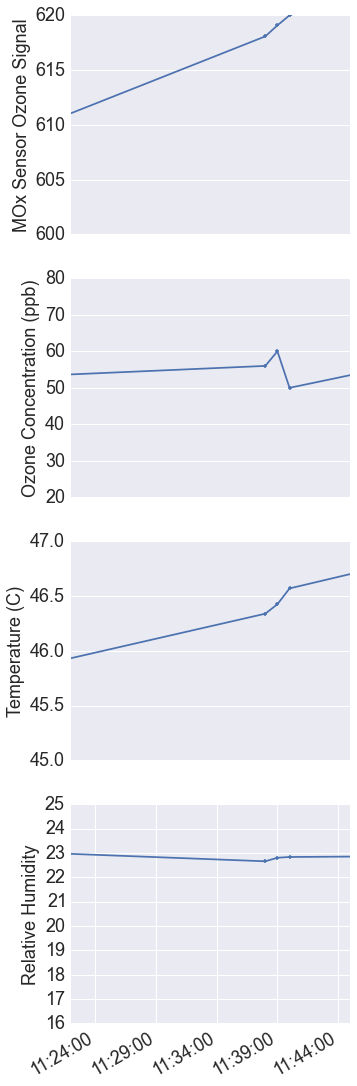

In [12]:
plot_03_temp_rh_no_scale(df_all, pod_number, ref_column, 'Training Data', cutoff_value, 5)

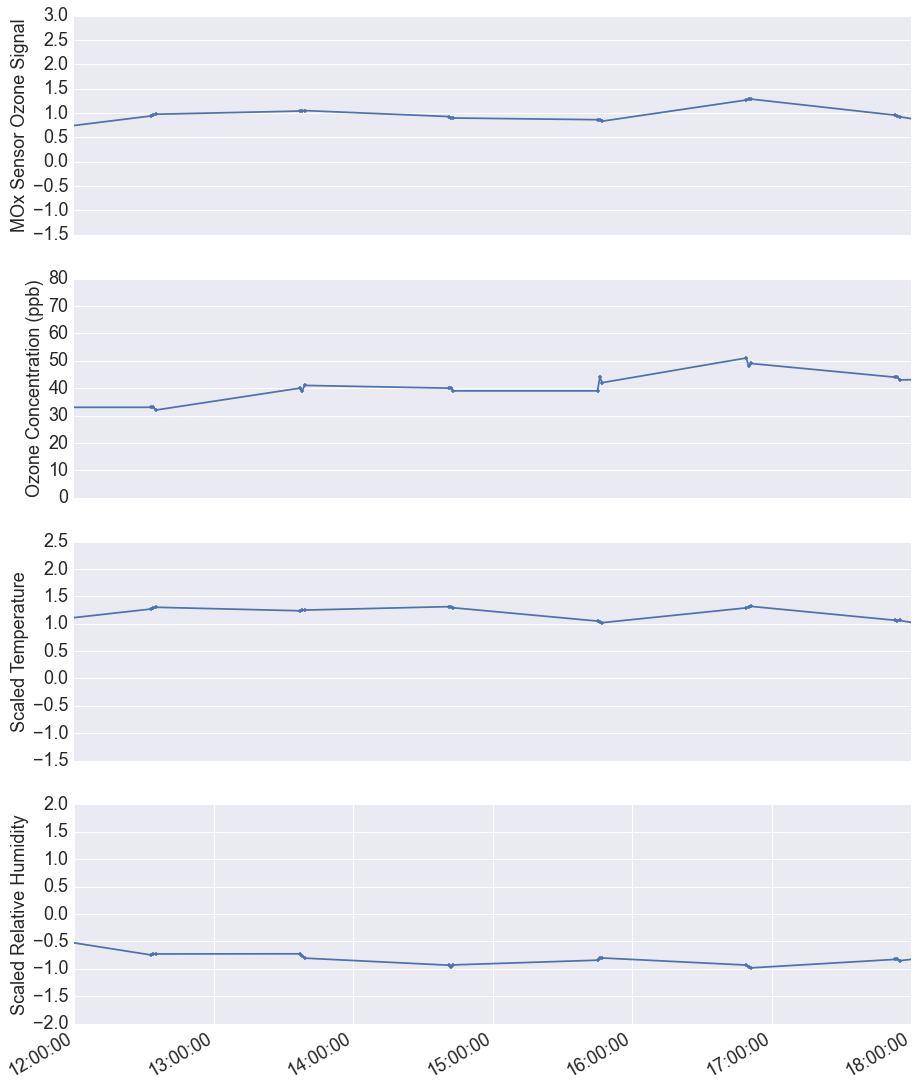

In [13]:
plot_03_temp_rh(df_tr, pod_number, ref_column, 'Training Data', cutoff_value, 4)

####Plot the training ozone

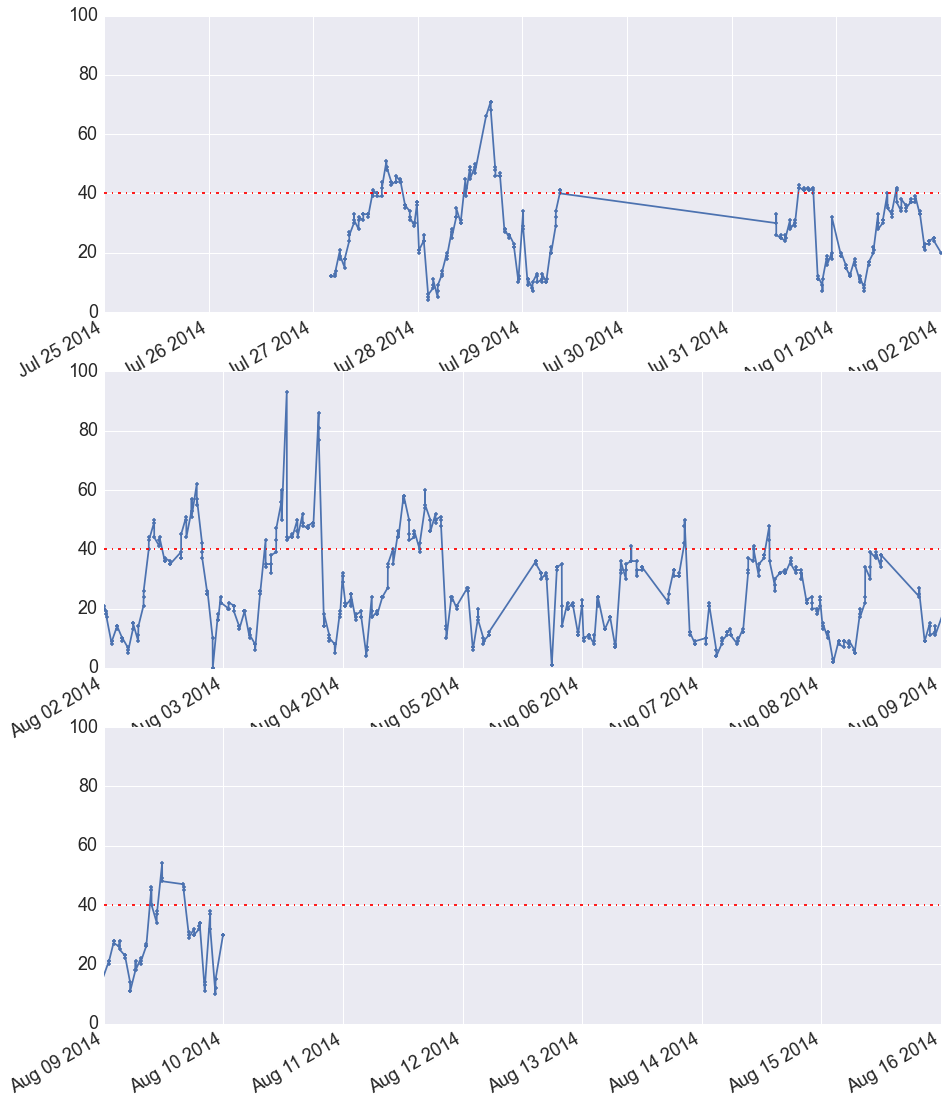

In [14]:
plot_tr_and_holdout(df_tr, pod_number, ref_column, 'Training Data', cutoff_value)

###Plot holdout ozone to make sure that the holdout set has some high-value ozone measurements.

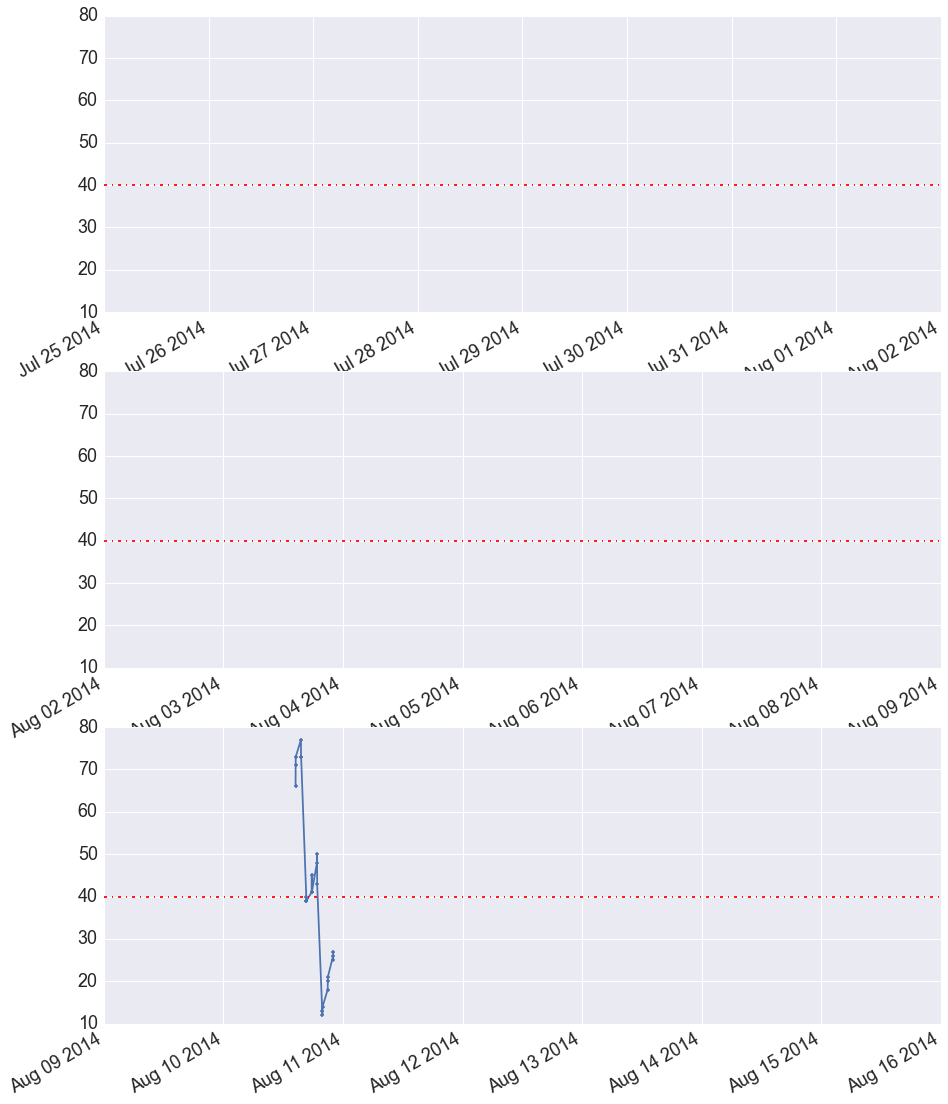

In [15]:
plot_tr_and_holdout(df_hold, pod_number, ref_column, 'Holdout Data', cutoff_value)

###Declare a multiplication factor for the MSE part of the custom score function.

In [16]:
cust_mse_fact = 1

#Linear Regression with Base Features

In [17]:
base_features = [pod_ozone,'Temp','Rh', 'no2']

/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


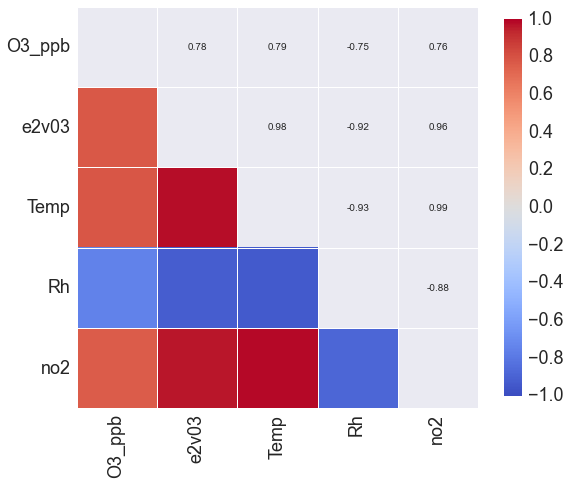

In [18]:
f, ax = plt.subplots(figsize=(9, 9))
sns.corrplot(df_tr[[ref_column] + base_features], annot=True, sig_stars=False,
             diag_names=False, ax=ax)

In [19]:
#Define the model.
lin_regr = linear_model.LinearRegression()
#find the MSE
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_base, y_cv, df_cv_lin_base, df_H_lin_base = cross_validation_by_day(lin_regr, base_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 21.0 , CV High Diff. in Mean (>40): -17.6
Holdout RMSE: 19.0 , High-Value Holdout RMSE: 33.0 , Holdout High Diff. in Mean.: -32.4


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


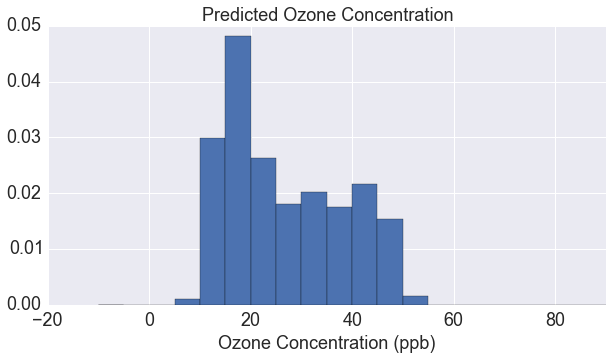

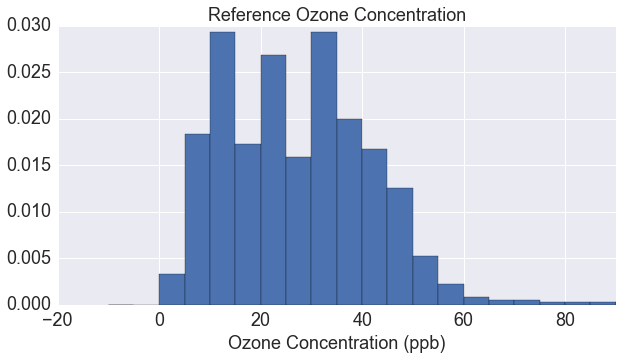

In [20]:
plot_hist(X_pred_cv_base, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_base, 'Reference Ozone Concentration')

####Plot the learning curve for a linear regression with the base features.

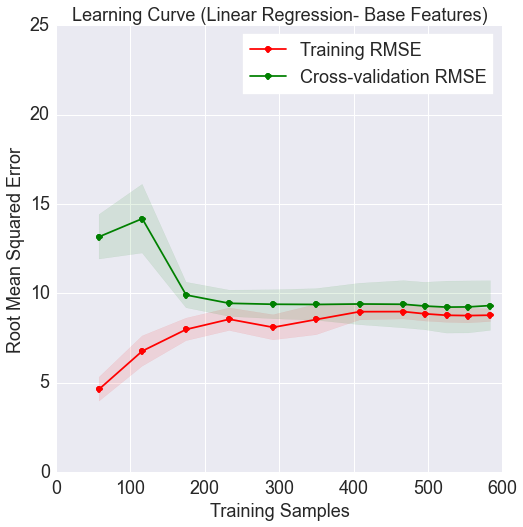

In [21]:
plt = plot_learning_curve(lin_regr, "Learning Curve (Linear Regression- Base Features)", df_tr[base_features].values, df_tr[ref_column].values, (0,25), days_tr, np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]))

The MSE is high for the cross-validation set in this plot, and the training and cross-validation scores come together in this plot tells us that we have resonably high bias. Create more features and add polynomial effects to reduce bias. 

###Plot the residuals and comparison curves.

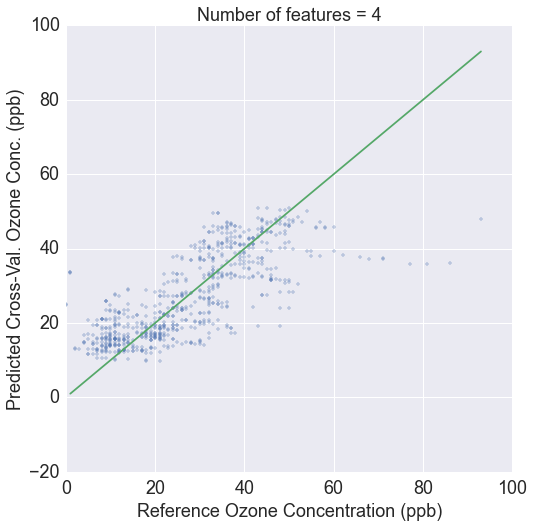

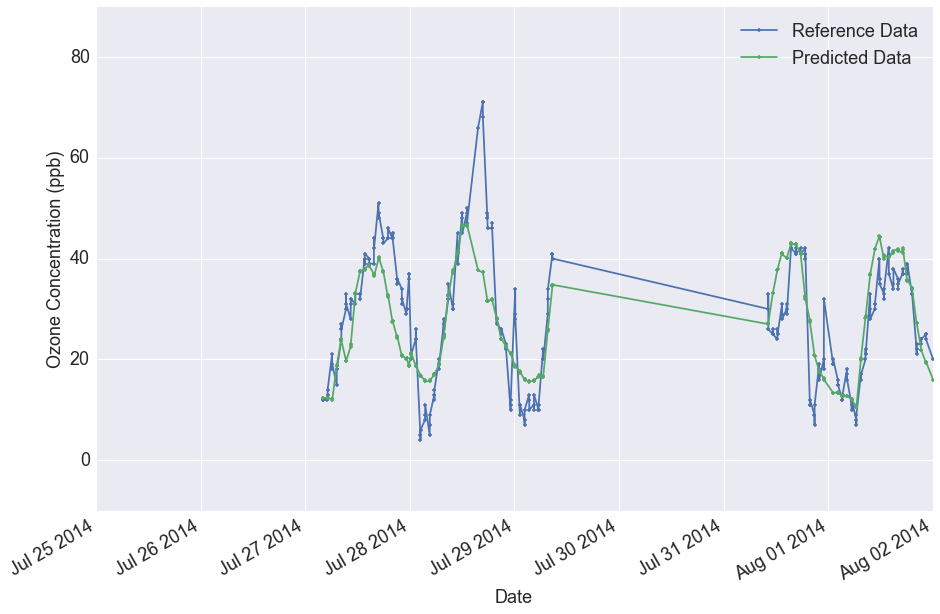

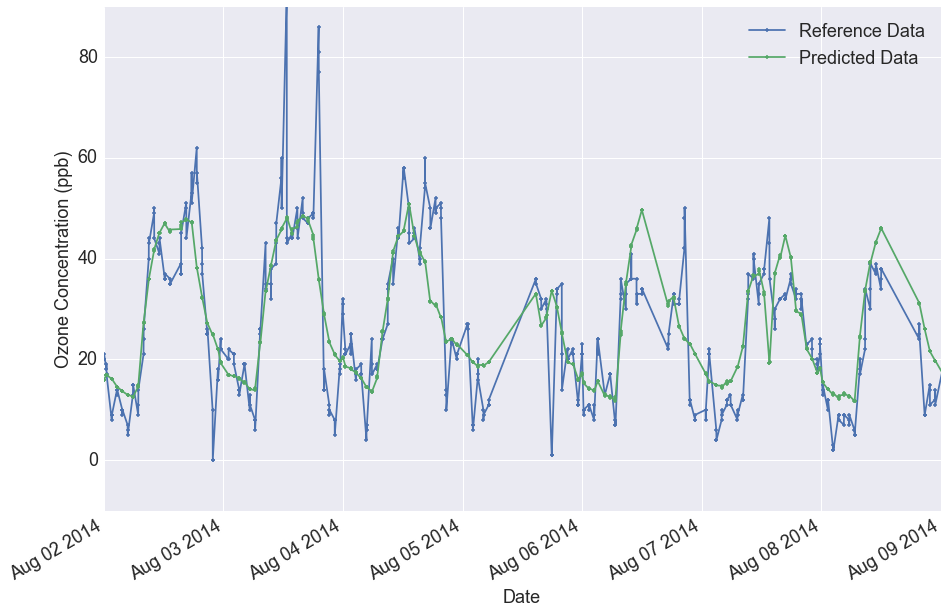

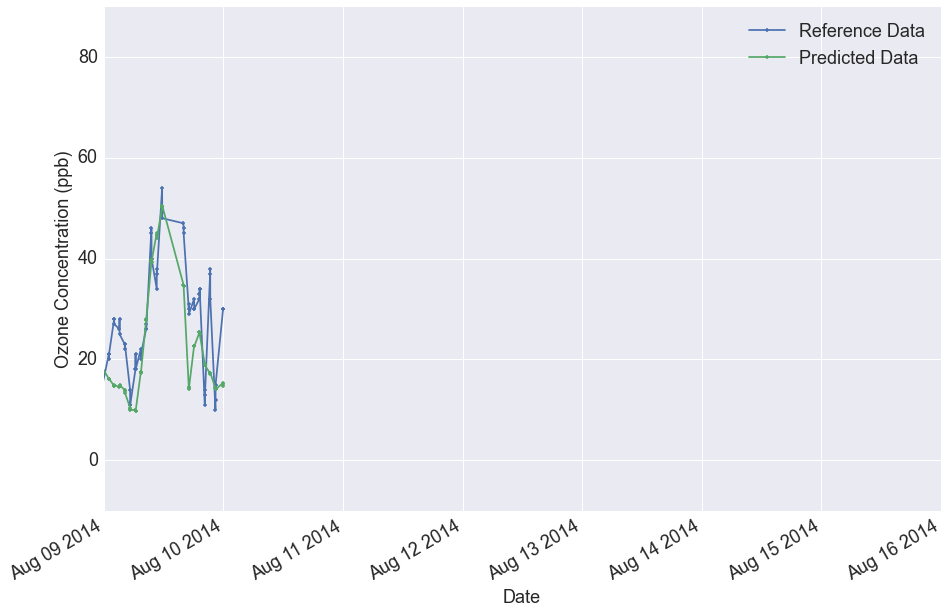

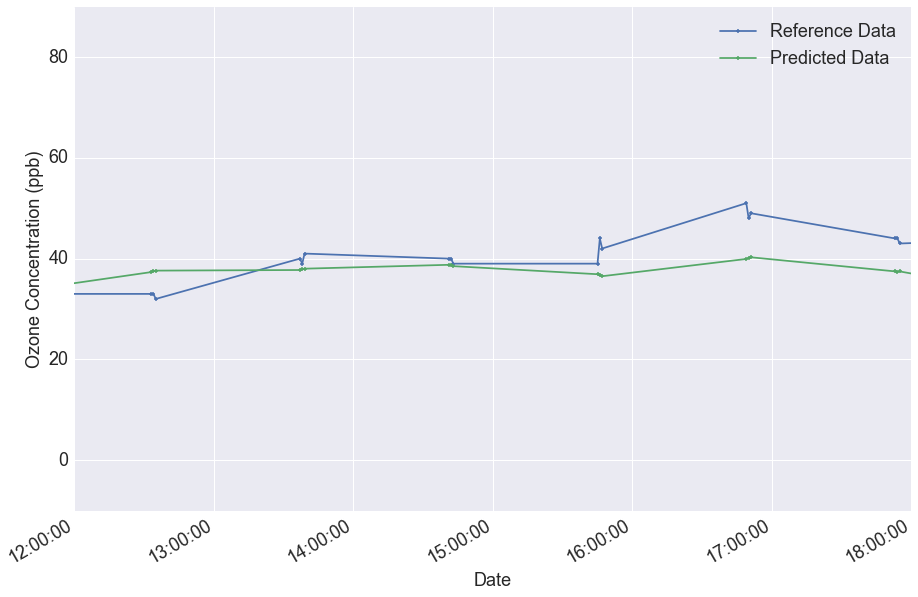

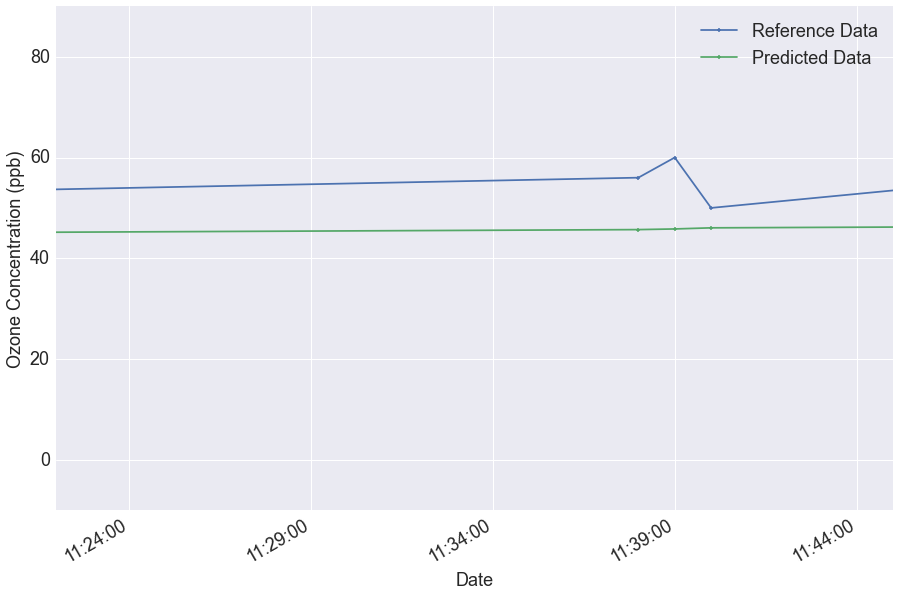

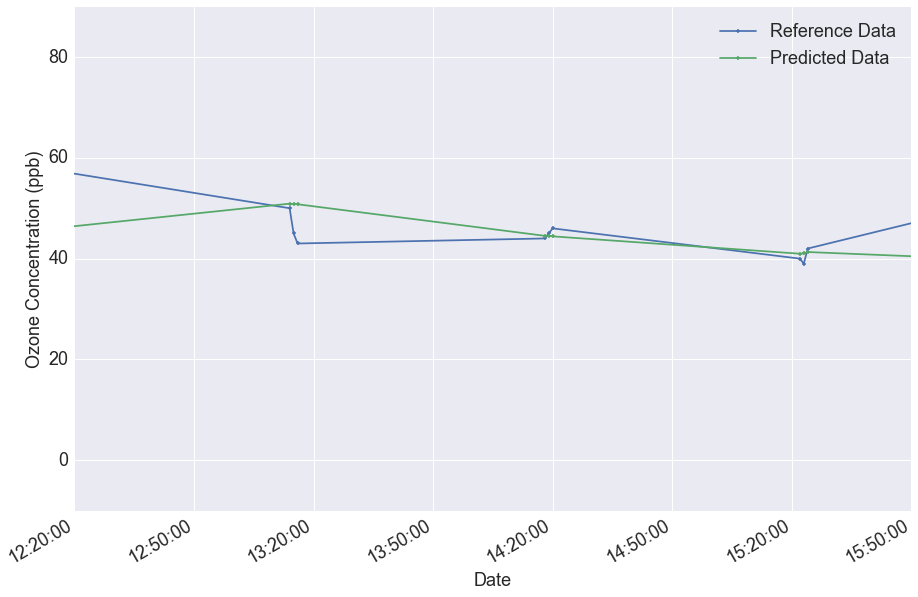

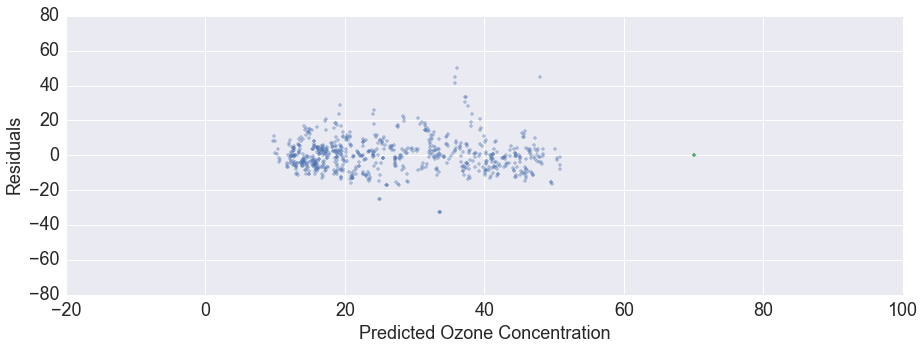

In [22]:
num_good_feat = len(base_features)
fitted_vs_ref_plot(df_cv_lin_base, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_base, ref_column)

#Linear Regression with All Features.

In [23]:
every_feature = list(df_tr.ix[:,0:len(df_scaled.columns)])
leave_out = ['ref_o3_smooth', 'chunk', 'day', 'O3_ppb', 'UnixTime']
all_features = [f for f in every_feature if f not in leave_out]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_all, y_cv, df_cv_lin_all, df_H_lin_all = cross_validation_by_day(lin_regr, all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 7.3
Cross-Validation RMSE: 10.0 , High-Value CV RMSE: 24.0 , CV High Diff. in Mean (>40): -15.5
Holdout RMSE: 15.0 , High-Value Holdout RMSE: 23.0 , Holdout High Diff. in Mean.: -22.0


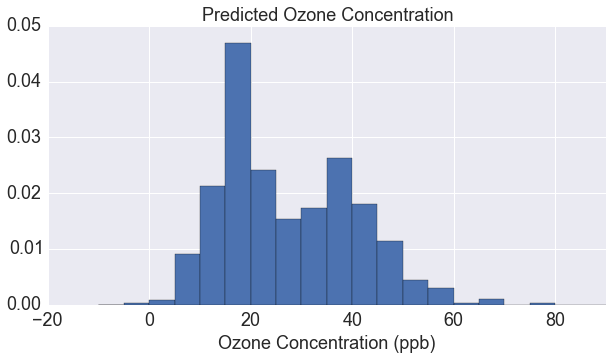

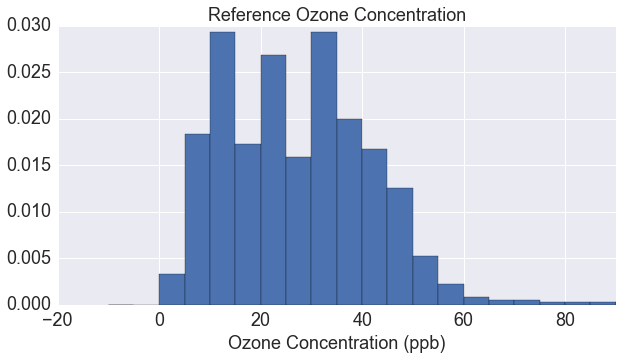

In [24]:
plot_hist(X_pred_cv_all, y_cv, 'Predicted Ozone Concentration')
plot_hist(y_cv, X_pred_cv_all, 'Reference Ozone Concentration')

###Plot the residuals and comparison curves.

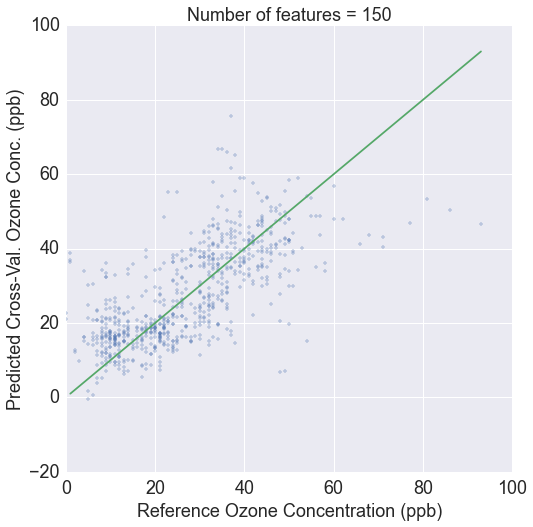

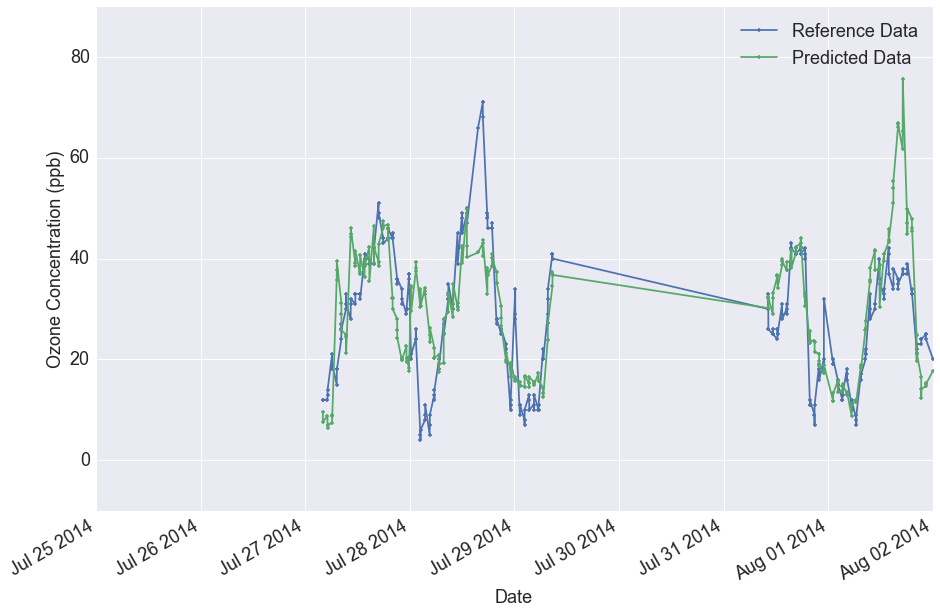

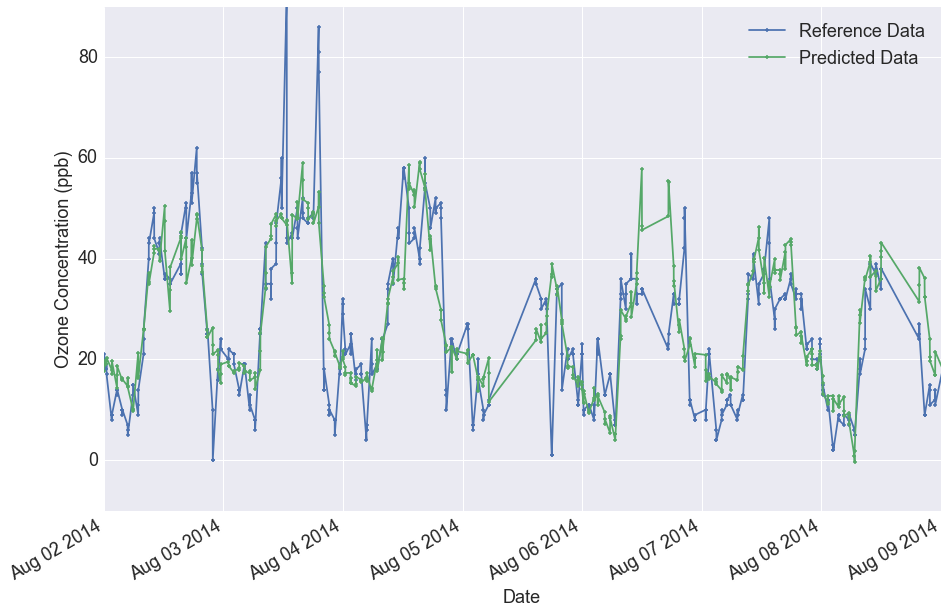

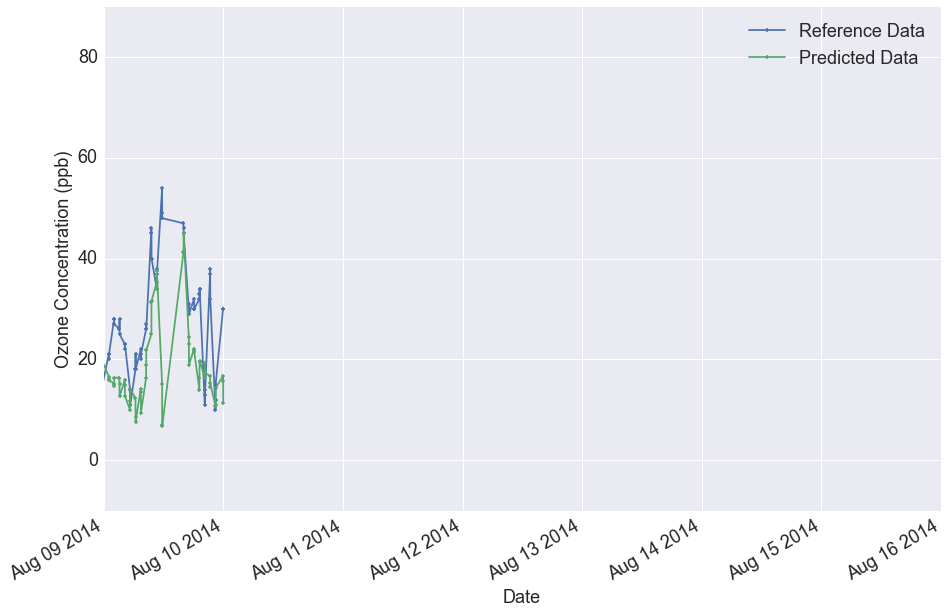

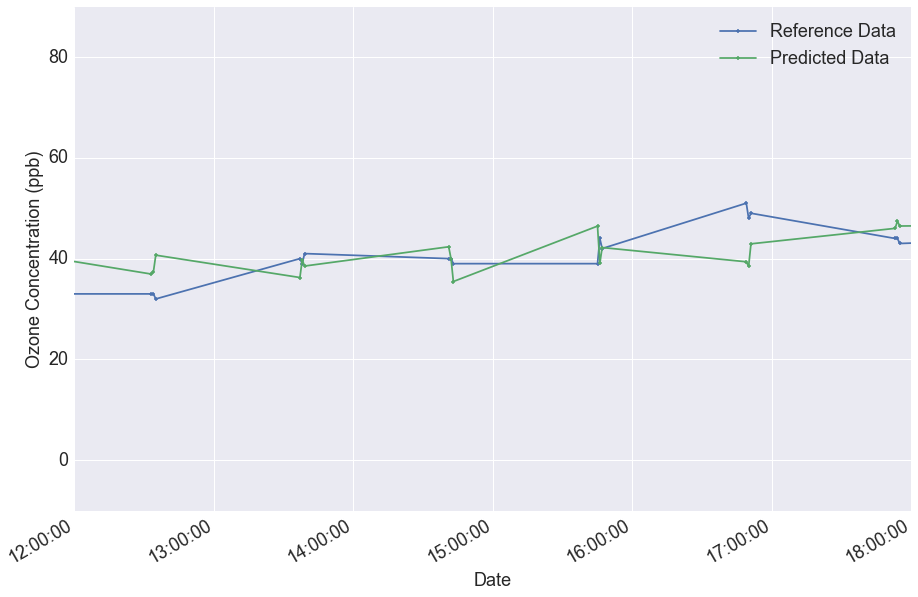

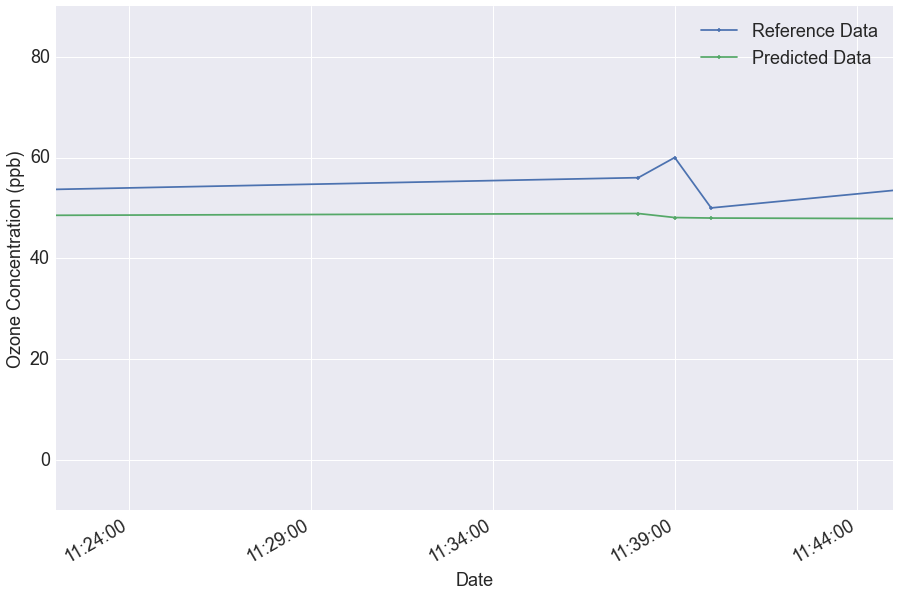

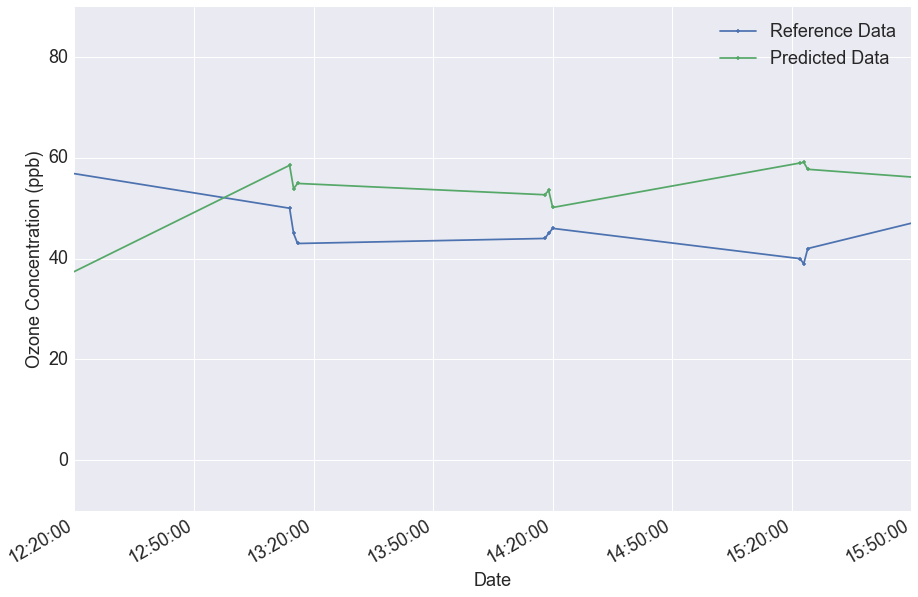

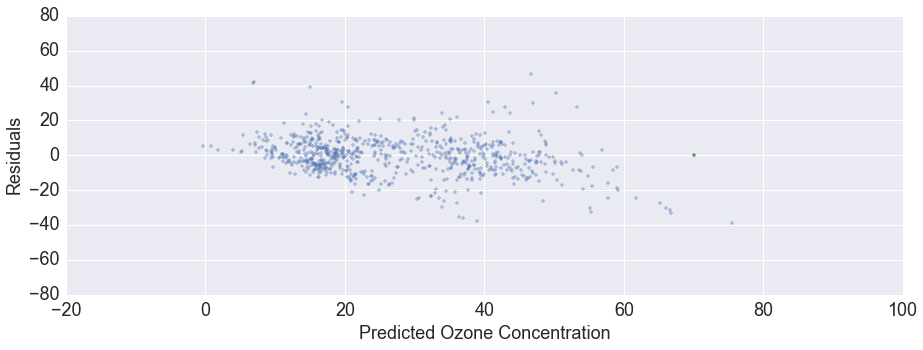

In [25]:
num_good_feat = len(all_features)
fitted_vs_ref_plot(df_cv_lin_all, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lin_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lin_all, ref_column)

#Forward Selection

####Declare rather you want to use MSE or a custom error function:

In [26]:
#make a list of features from the column titles in the dataframe
features_all = list(df_tr.columns)
leave_out = ['Zenith Angle [degrees]','UnixTime', 'pod_o3_smooth', 'O3_ppb', 'ref_o3_smooth', ref_column, 'chunk']
features = [f for f in features_all if f not in leave_out]
features_it = [f for f in features if f not in 'day']
fs_features, score, RMSE = forward_selection_lodo(lin_regr, features_it, df_tr[[ref_column] + features].dropna(), 'custom_mse', ref_column, days_tr, 15, cust_mse_fact, cutoff_value)

9223372036854775807
Next best Feature:  ln_temp_int_lag_4 , Score:  10.5 RMSE:  3.2 #: 1
9223372036854775807
Next best Feature:  ln_O3_slope_lead_1 , Score:  10.5 RMSE:  3.5 #: 2
9223372036854775807
Next best Feature:  e2v03_slope_lead_2 , Score:  10.5 RMSE:  4.3 #: 3
9223372036854775807
Next best Feature:  ln_temp_slope_lead_5 , Score:  10.4 RMSE:  2.6 #: 4
9223372036854775807
Next best Feature:  e2v03_slope_lead_5 , Score:  10.4 RMSE:  2.8 #: 5
9223372036854775807
Next best Feature:  e2v03_int_lag_1 , Score:  10.4 RMSE:  2.8 #: 6
9223372036854775807
Next best Feature:  e2v03_int_lead_1 , Score:  10.4 RMSE:  2.8 #: 7
9223372036854775807
Next best Feature:  ln_O3_int_lag_1 , Score:  10.4 RMSE:  2.8 #: 8
9223372036854775807
Next best Feature:  ln_O3_int_lead_1 , Score:  10.4 RMSE:  2.8 #: 9
9223372036854775807
Next best Feature:  Temp_int_lag_1 , Score:  10.4 RMSE:  2.8 #: 10
9223372036854775807
Next best Feature:  Temp_int_lead_1 , Score:  10.4 RMSE:  2.8 #: 11
9223372036854775807
Next

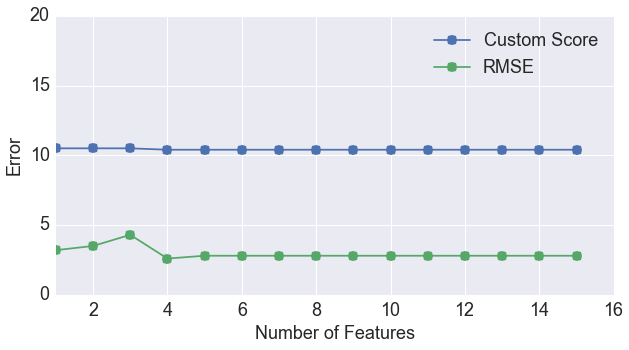

In [30]:
plot_error_vs_features(score, RMSE, [0,20], [1,16])

#### Plot cross-validation fitted data versus reference data, and choose number of features.

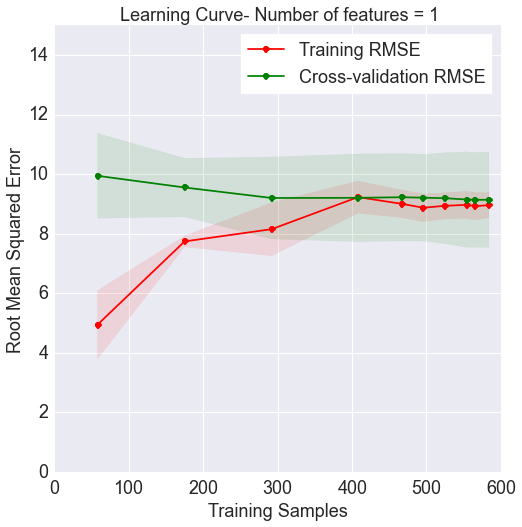

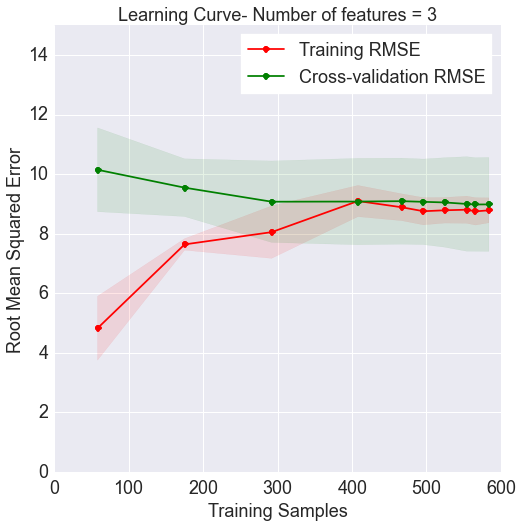

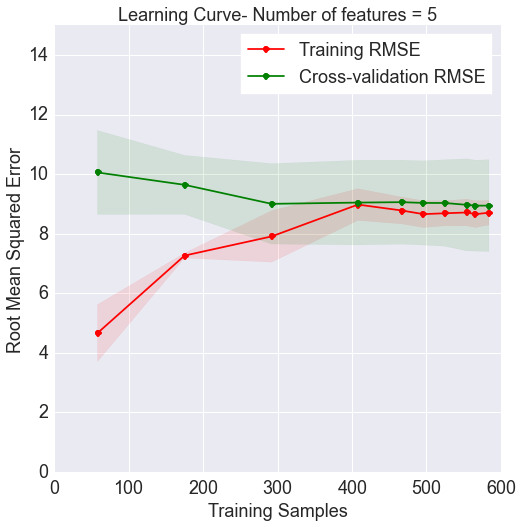

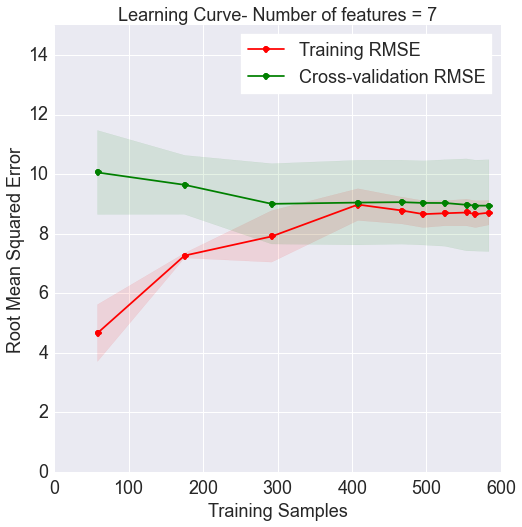

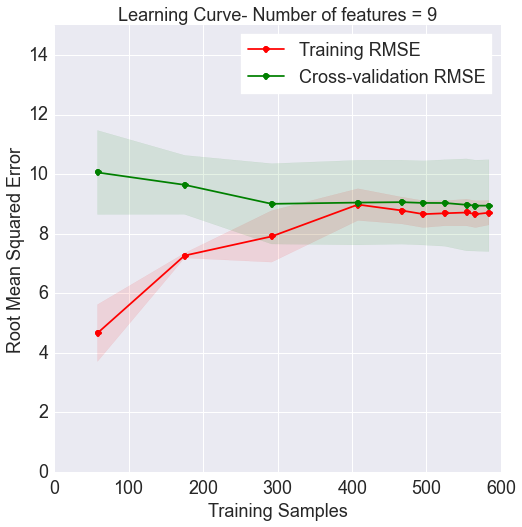

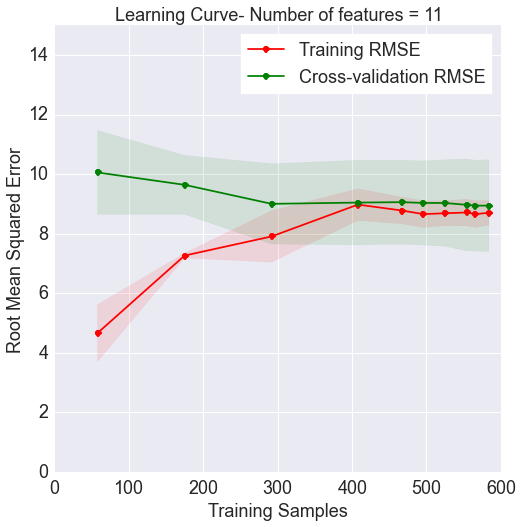

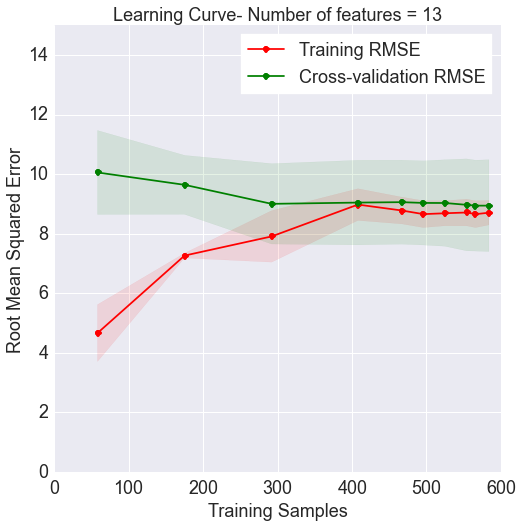

In [33]:
i = 1
while i < 15:
    num_good_feat = i
    #df_cv_1, df_H_1 = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
    #fitted_vs_ref_plot(df_cv_1, i, ref_column) 
    plot_learning_curve(lin_regr, "Learning Curve- Number of features = " + str(i), df_tr[fs_features[:i]].values, df_tr[ref_column].values, (0,15), 5, np.array([0.1, 0.3, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95,0.97, 1.0]))
    i += 2

#### Enter the chosen number of features, and perform a linear regression.

In [34]:
num_good_feat = 4
best_features = fs_features[:num_good_feat]
MSE_CV, MSE_T, MSE_H, high_MSE_cv, X_pred_cv_best, y_cv_best, df_cv_lin_best, df_H_lin_best = cross_validation_by_day(lin_regr, best_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.8
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 19.0 , CV High Diff. in Mean (>40): -17.3
Holdout RMSE: 19.0 , High-Value Holdout RMSE: 31.0 , Holdout High Diff. in Mean.: -29.9


#### Print Best Features

In [35]:
best_features

['ln_temp_int_lag_4',
 'ln_O3_slope_lead_1',
 'e2v03_slope_lead_2',
 'ln_temp_slope_lead_5']

In [143]:
X = df_scaled[best_features].values
y = df_scaled[ref_column].values
lin_regr.fit(X, y)
pred = lin_regr.predict(X)
df_pred = pd.DataFrame({'pred':pred}, index=df_scaled.index)

#### Find the beginning of each run.

In [144]:
def find_avg_close(df):
    start_time = []
    closed_avg = []
    flux = []
    count = 0
    for row in range(1,len(df)):
        if (df.index[row] - df.index[row-1]) > pd.Timedelta(minutes=3):
            start_time.append(df.index[row])
            closed_avg.append(round(df.pred[row:row+3].median(), 1))
            count += 1
    return closed_avg, start_time

In [145]:
closed_avg, start_time = find_avg_close(df_pred)

In [178]:
df_flux = pd.DataFrame(closed_avg, index = start_time, columns = ['closed_c'])
df_flux.head()

closed_c
2014-07-27 05:06:00      12.5
2014-07-27 06:10:00      14.8
2014-07-27 07:13:00      17.9
2014-07-27 08:17:00      24.1
2014-07-27 09:21:00      29.3

In [179]:
df_flux.to_csv("closed_conc.csv")

#### Import the open concentrations

In [180]:
df_open = pd.DataFrame.from_csv('open_conc.csv')

In [181]:
df_open_close = pd.concat([df_open, df_flux], join='outer', axis=1)

In [182]:
df_open_close.head()

Open Conc.  closed_c
2014-07-27 05:06:00         NaN      12.5
2014-07-27 06:10:00         NaN      14.8
2014-07-27 07:13:00         NaN      17.9
2014-07-27 08:17:00         NaN      24.1
2014-07-27 09:21:00         NaN      29.3

In [203]:
df_open_close.rename(columns={'Open Conc.': 'open_c'}, inplace=True)

In [217]:
count = 0
flux = []
close_time = []
for idx, row in df_open_close.iterrows():
    try:
        if df_open_close.index[count+1] - idx < pd.Timedelta(minutes=30):
            flux.append(-(0.0015/0.1574)*(row['open_c']-df_open_close.closed_c[count+1])*584.6529/(298))
            close_time.append(idx)
    except:
        pass
    count += 1

In [220]:
df_flux = pd.DataFrame({'flux':flux}, index=close_time)

In [223]:
df_flux

flux
2014-07-28 15:24:00 -0.336543
2014-07-28 16:28:00 -0.299150
2014-07-28 17:32:00 -0.278583
2014-07-28 18:36:00 -0.340283
2014-07-28 19:40:00 -0.231841
2014-07-28 20:44:00 -0.190708
2014-07-28 21:48:00 -0.183229
2014-07-28 22:52:00 -0.172011
2014-07-28 23:56:00 -0.142096
2014-07-29 01:00:00 -0.132748
2014-07-29 02:04:00 -0.123399
2014-07-29 03:08:00 -0.114051
2014-07-29 04:12:00 -0.117790
2014-07-29 05:16:00 -0.115920
2014-07-29 06:19:00 -0.048612
2014-07-29 07:23:00 -0.157054
2014-07-29 08:27:00 -0.244929
2014-07-31 09:57:00 -0.016827
2014-07-31 11:01:00 -0.228102
2014-07-31 12:05:00 -0.175750
2014-07-31 13:08:00 -0.256147
2014-07-31 14:12:00 -0.271104
2014-07-31 15:16:00 -0.345892
2014-07-31 16:19:00 -0.379546
2014-07-31 17:23:00 -0.400113
2014-07-31 18:27:00 -0.362719
2014-07-31 19:31:00 -0.304759
2014-07-31 20:35:00 -0.213144
2014-07-31 21:39:00 -0.198187
2014-07-31 22:43:00 -0.256147
...                       ...
2014-08-09 22:09:00 -0.149575
2014-08-09 23:40:00 -0.138357
2014-08-09 23:55:00       NaN
2014-08-10 00:18:00 -0.140226
2014-08-10 01:22:00 -0.168272
2014-08-10 02:26:00 -0.158923
2014-08-10 03:31:00 -0.108442
2014-08-10 04:35:00 -0.106572
2014-08-10 05:39:00 -0.074787
2014-08-10 06:43:00 -0.063569
2014-08-10 07:47:00 -0.132748
2014-08-10 08:52:00 -0.175750
2014-08-10 09:56:00 -0.192578
2014-08-10 11:00:00 -0.237450
2014-08-10 12:05:00 -0.317846
2014-08-10 13:09:00 -0.373937
2014-08-10 14:14:00 -0.308498
2014-08-10 15:18:00 -0.299150
2014-08-10 16:23:00 -0.336543
2014-08-10 17:27:00 -0.295410
2014-08-10 18:32:00 -0.372067
2014-08-10 19:36:00 -0.181359
2014-08-10 20:41:00 -0.048612
2014-08-10 21:45:00 -0.080396
2014-08-10 22:50:00 -0.108442
2014-08-10 23:05:00       NaN
2014-08-10 23:13:00 -0.112181
2014-08-10 23:28:00       NaN
2014-08-10 23:55:00 -0.138357
2014-08-11 00:59:00 -0.104702

[248 rows x 1 columns]

### Plot the cross-validation data and residuals below.

In [36]:
ref_column

'O3_ppb'

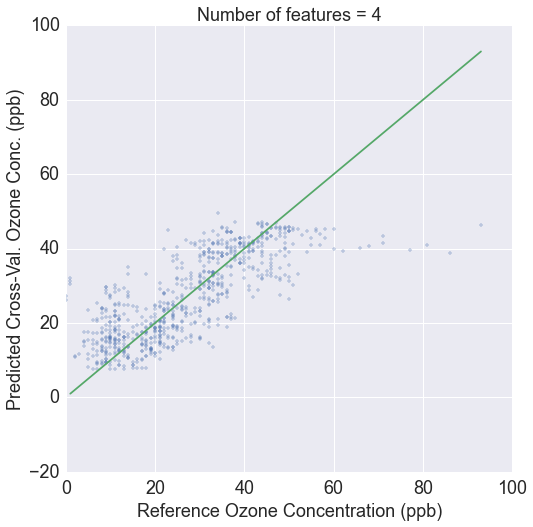

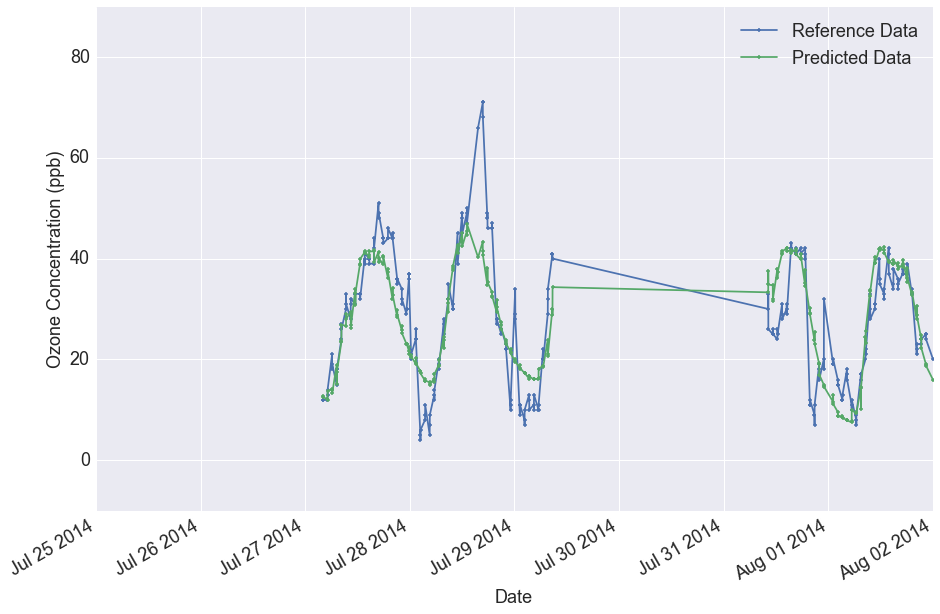

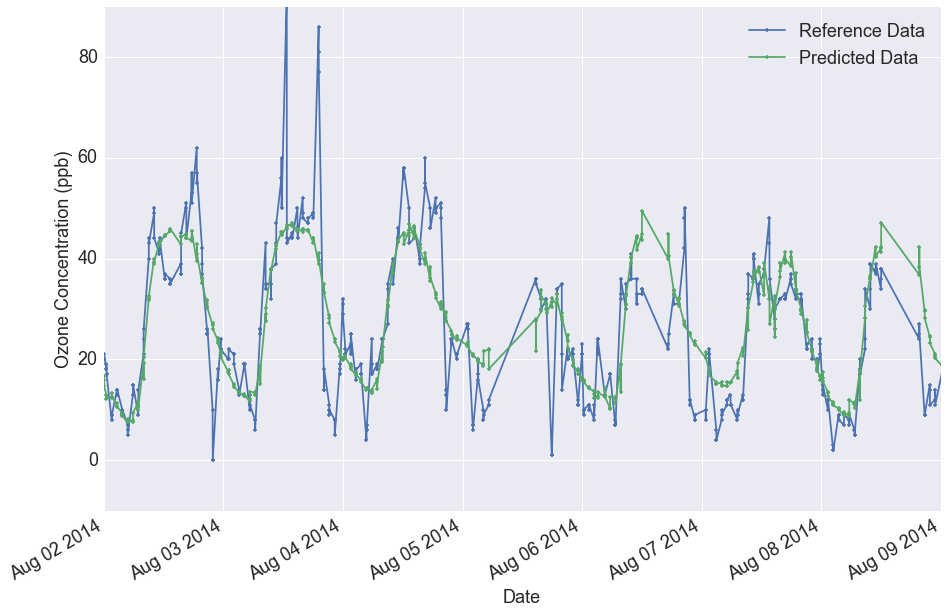

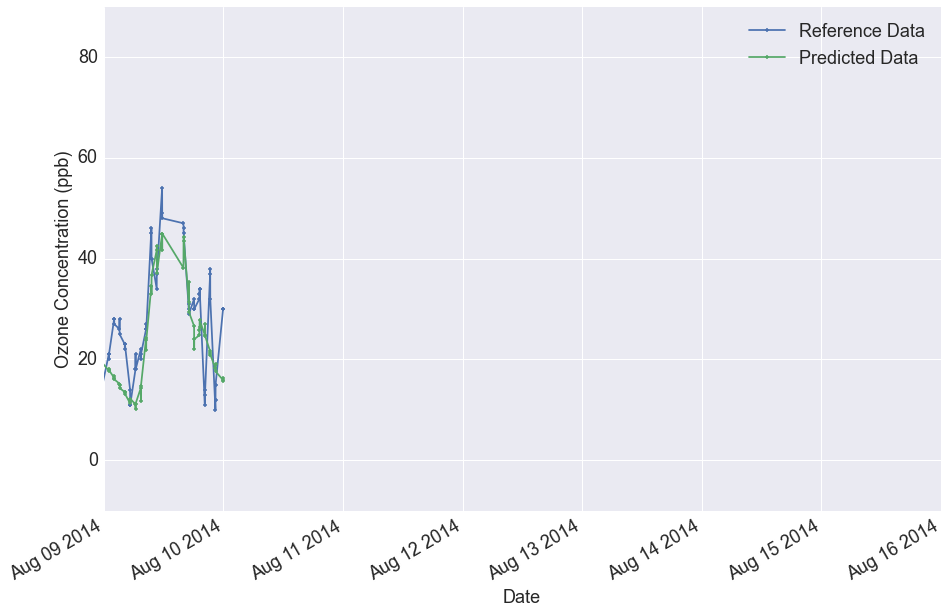

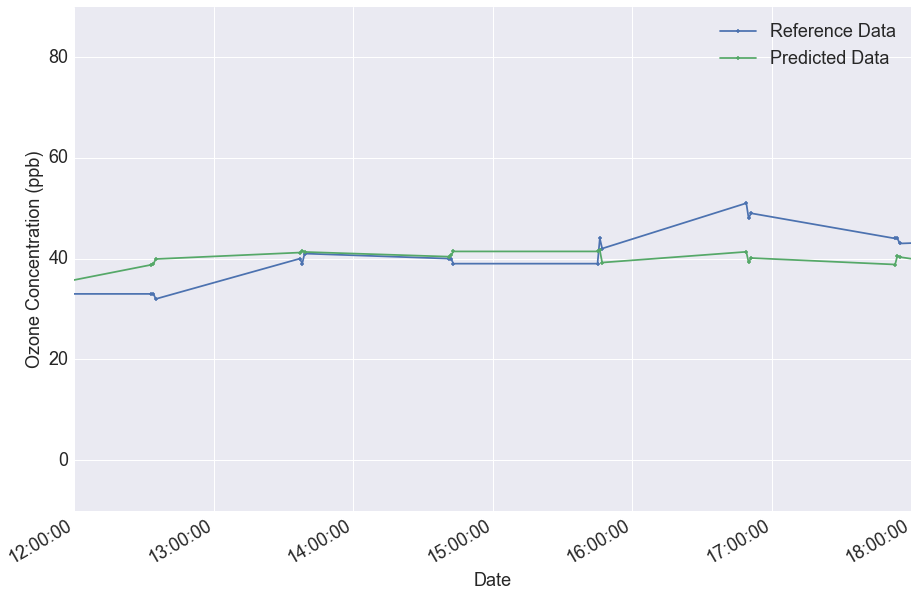

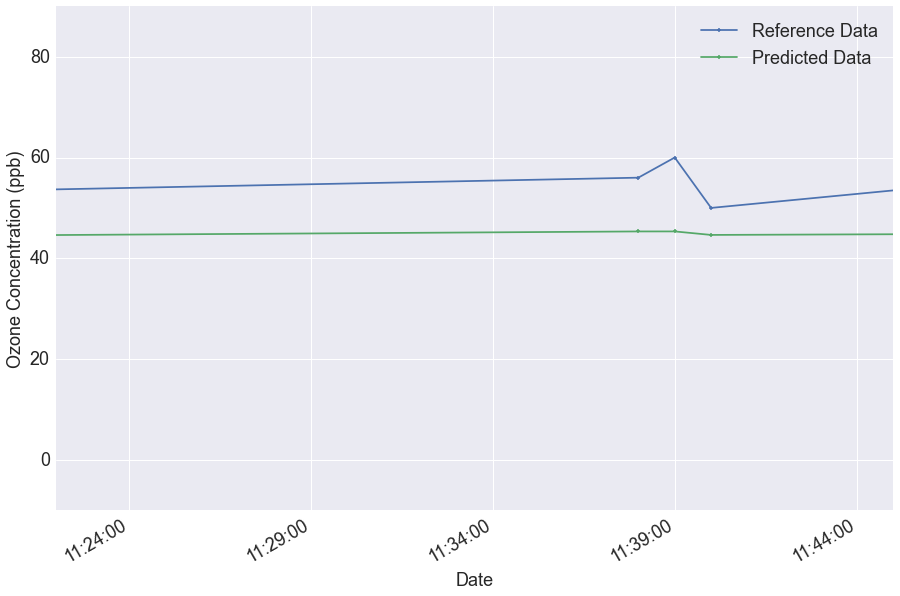

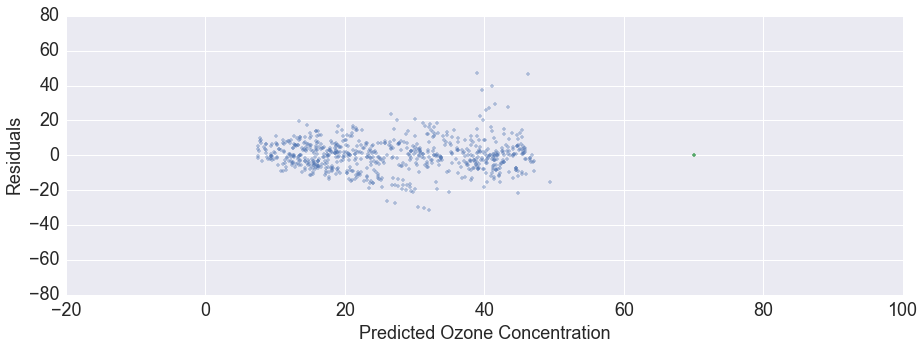

In [43]:
df_lin_regr_best_feat_cv, df_lin_regr_best_feat_H  = find_fitted_cv_values_for_best_features(df_tr, df_hold, fs_features, num_good_feat, linear_model.LinearRegression(), chunks_tr, ref_column)
fitted_vs_ref_plot(df_lin_regr_best_feat_cv, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_lin_regr_best_feat_cv, pod_number, 5, ref_column)
resid = plot_resid_vs_conc(df_lin_regr_best_feat_cv, ref_column)

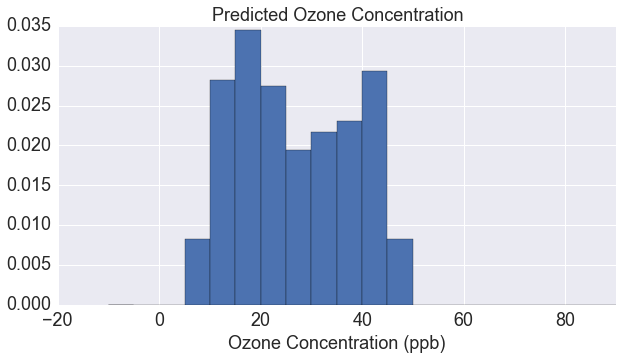

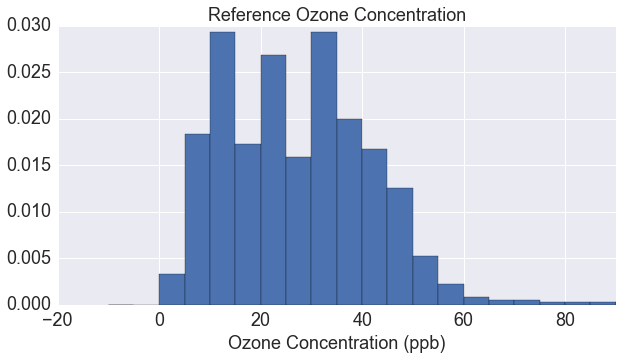

In [44]:
plot_hist(X_pred_cv_best, y_cv_best, 'Predicted Ozone Concentration')
plot_hist(y_cv_best, X_pred_cv_best, 'Reference Ozone Concentration')

## Ridge Regression- All Features

In [65]:
fs_features = all_features
num_good_feat_ridge = len(all_features)

In [66]:
#define the training data
df_fits = df_tr[fs_features[:num_good_feat_ridge] + [ref_column] + ['day']].dropna()
X = df_scaled[fs_features[:num_good_feat_ridge]].values
y = df_scaled[ref_column].values

#### Find the best lambda value using cross-validation

In [47]:
best_lambda_ridge, lambda_ridge, coefs, mean_score_lambda = find_best_lambda(Ridge, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.0000001, 1000000, 3, cust_mse_fact, cutoff_value)

lambda: 1e-07
score: 12.15
lambda: 3e-07
score: 12.39
lambda: 9e-07
score: 12.61
lambda: 2.7e-06
score: 12.77
lambda: 8.1e-06
score: 12.91
lambda: 2.43e-05
score: 13.04
lambda: 7.29e-05
score: 13.12
lambda: 0.0002187
score: 13.11
lambda: 0.0006561
score: 13.05
lambda: 0.0019683
score: 12.95
lambda: 0.0059049
score: 12.74
lambda: 0.0177147
score: 12.44
lambda: 0.0531441
score: 12.2
lambda: 0.1594323
score: 12.05
lambda: 0.4782969
score: 11.92
lambda: 1.4348907
score: 11.72
lambda: 4.3046721
score: 11.43
lambda: 12.9140163
score: 11.2
lambda: 38.7420489
score: 11.1
lambda: 116.2261467
score: 11.08
lambda: 348.6784401
score: 11.1
lambda: 1046.0353203
score: 11.16
lambda: 3138.1059609
score: 11.39
lambda: 9414.3178827
score: 12.08
lambda: 28242.9536481
score: 13.82
lambda: 84728.8609443
score: 16.38
lambda: 254186.582833
score: 18.41
lambda: 762559.748499
score: 19.42
Best Lambda: 116.2261467


#### Plot the values of lambda versus the coefficients and the custom score. 

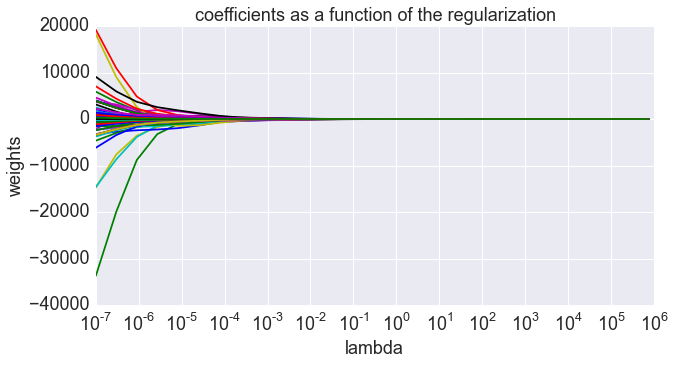

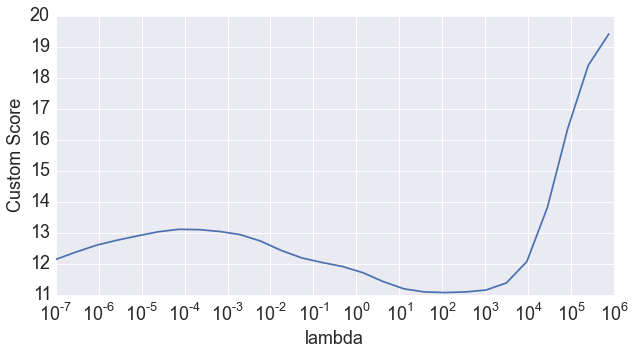

In [48]:
plot_lambda(lambda_ridge, coefs, mean_score_lambda)

#### Use the best lambda value found above to find errors.

In [49]:
MSE_CV_ridge, MSE_T_ridge, MSE_H_ridge, high_MSE_cv_ridge, X_pred_cv_ridge, y_cv_ridge, df_cv_ridge, df_H_ridge = cross_validation_by_day(Ridge(alpha = best_lambda_ridge), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.2
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 19.0 , CV High Diff. in Mean (>40): -15.8
Holdout RMSE: 18.0 , High-Value Holdout RMSE: 30.0 , Holdout High Diff. in Mean.: -29.3


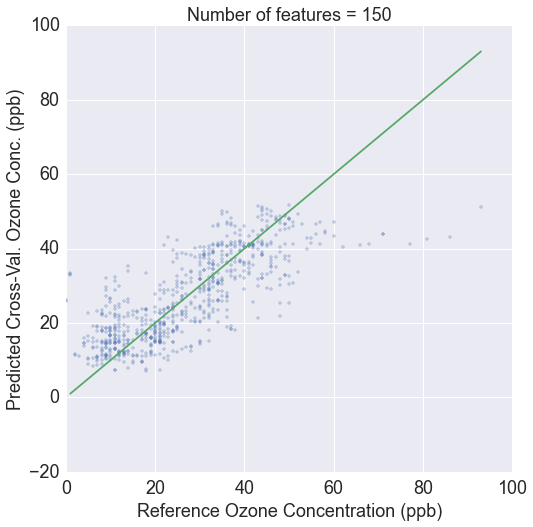

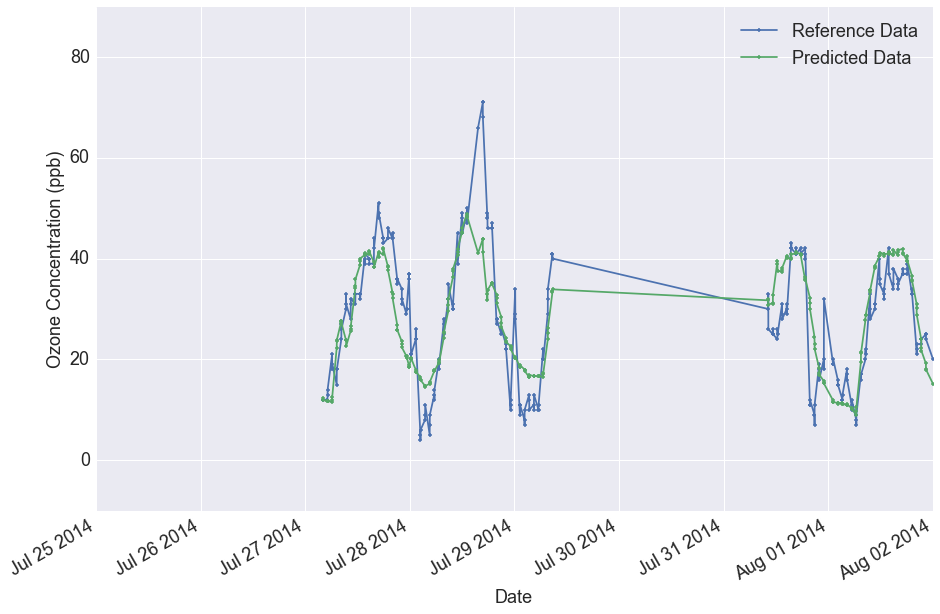

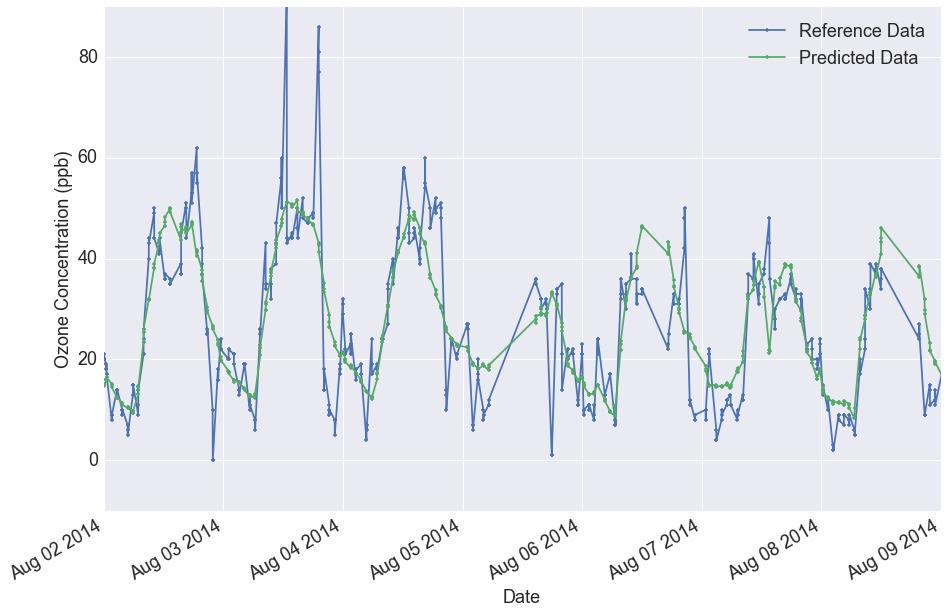

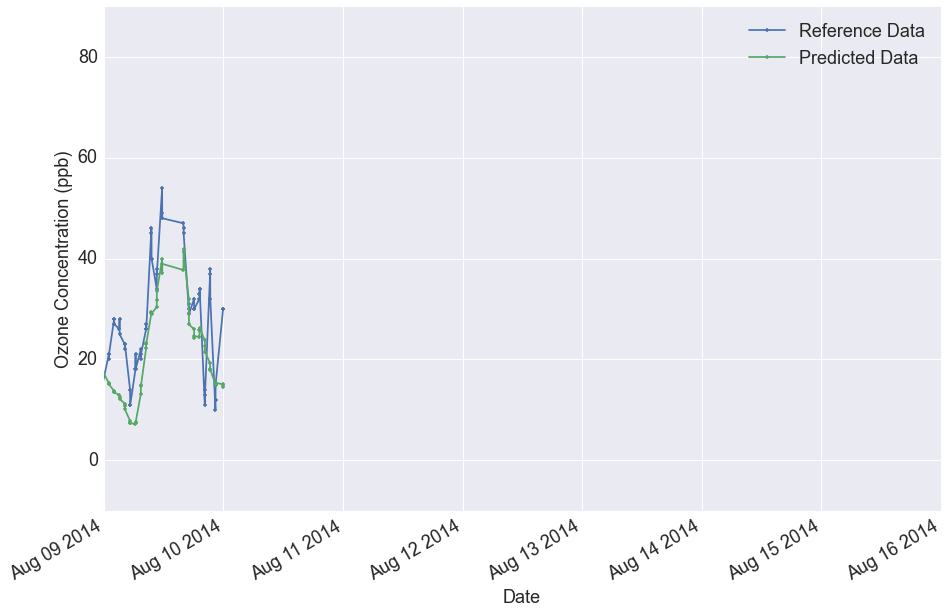

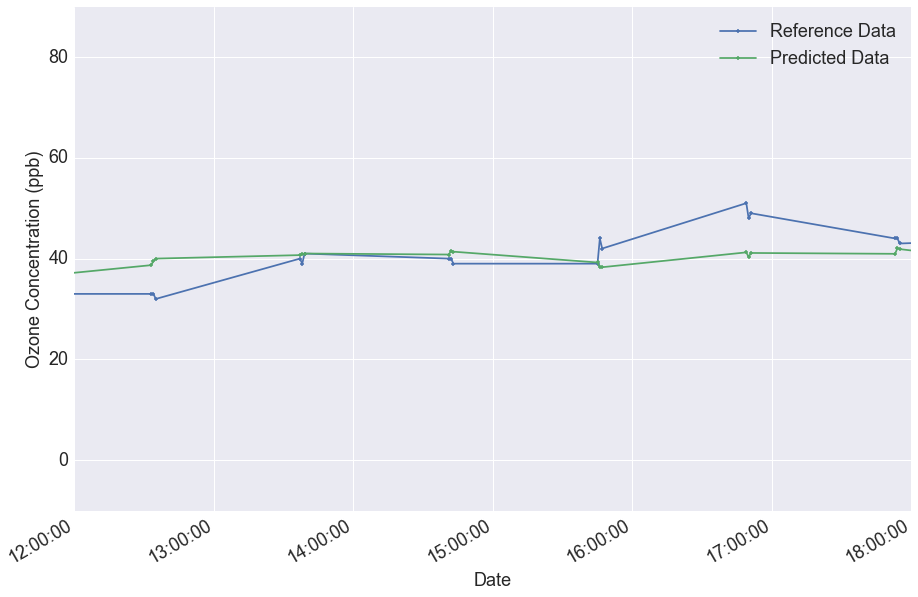

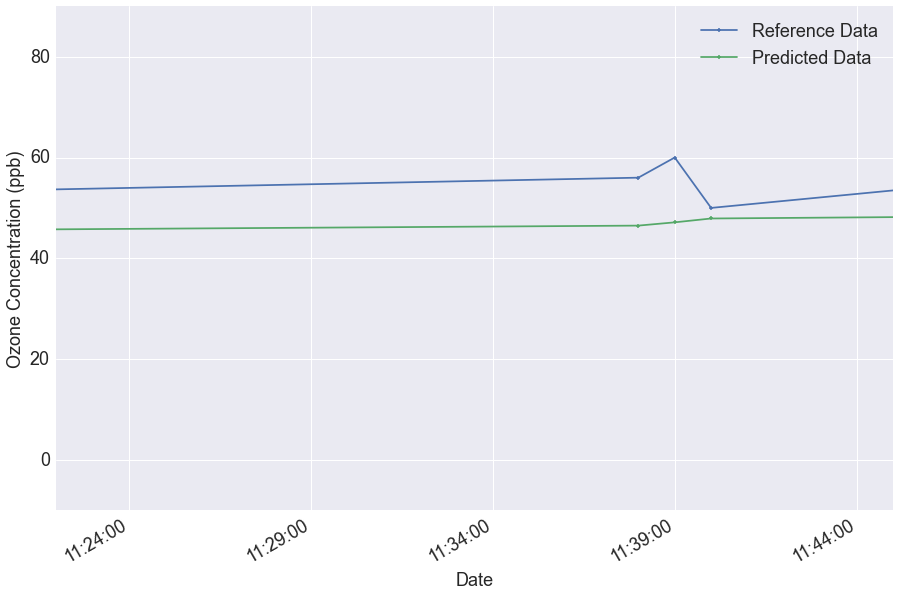

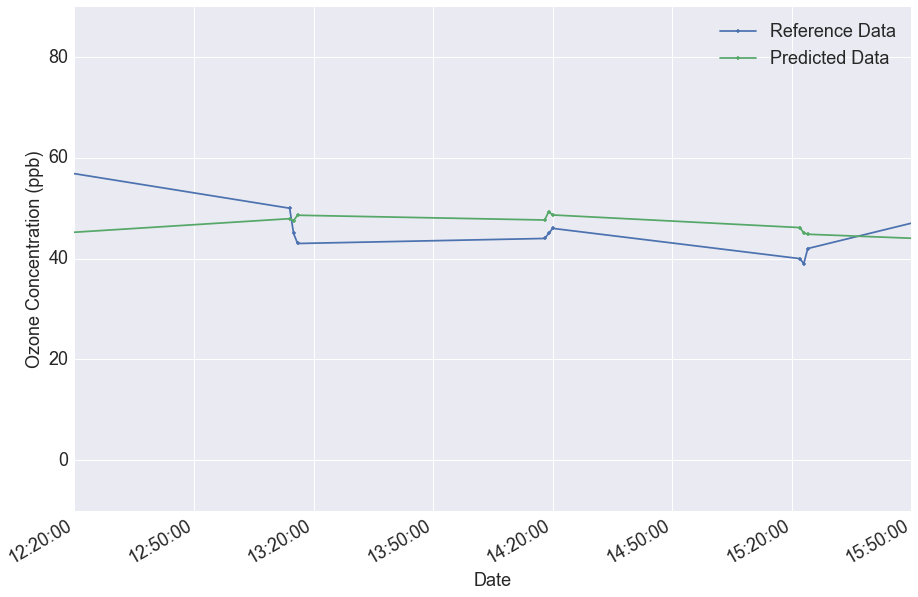

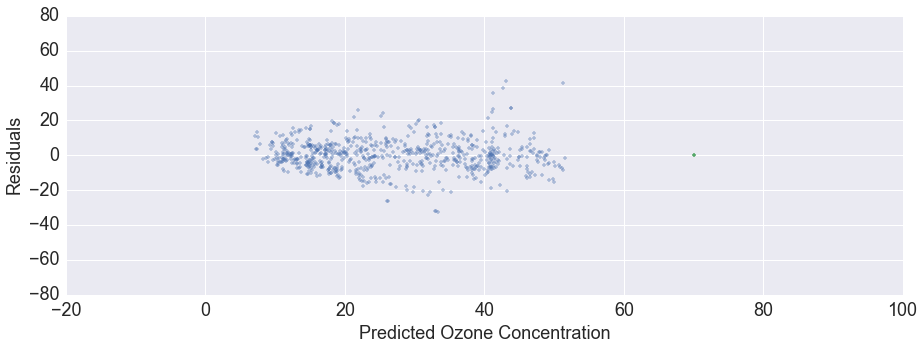

In [50]:
fitted_vs_ref_plot(df_cv_ridge, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_ridge, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_ridge, ref_column)

## Lasso- All Features

In [56]:
best_lambda_lasso, lambda_lasso, coefs_lasso, mean_score_lambda_lasso = find_best_lambda(Lasso, fs_features[:num_good_feat_ridge], df_fits, ref_column, 'custom_mse_scoring_function', days_tr, X, y, 0.000001, 100, 3, cust_mse_fact, cutoff_value)

lambda: 1e-06
score: 12.09
lambda: 3e-06
score: 12.09
lambda: 9e-06
score: 12.09
lambda: 2.7e-05
score: 12.09
lambda: 8.1e-05
score: 12.09
lambda: 0.000243
score: 12.08
lambda: 0.000729
score: 12.07
lambda: 0.002187
score: 12.03
lambda: 0.006561
score: 11.76
lambda: 0.019683
score: 11.36
lambda: 0.059049
score: 11.13
lambda: 0.177147
score: 11.25
lambda: 0.531441
score: 11.2
lambda: 1.594323
score: 11.67
lambda: 4.782969
score: 14.12
lambda: 14.348907
score: 20.03
lambda: 43.046721
score: 20.03
Best Lambda: 0.059049


/Users/berkeleyalmand/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


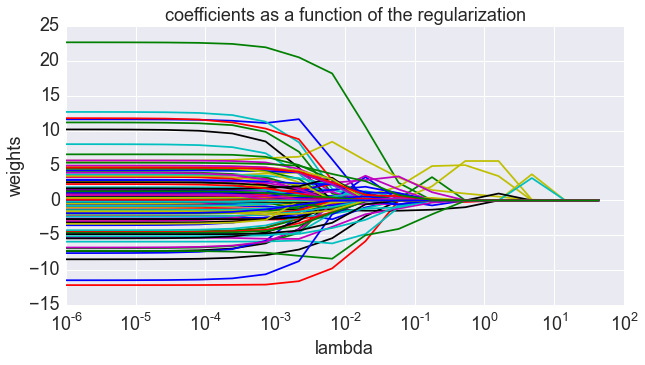

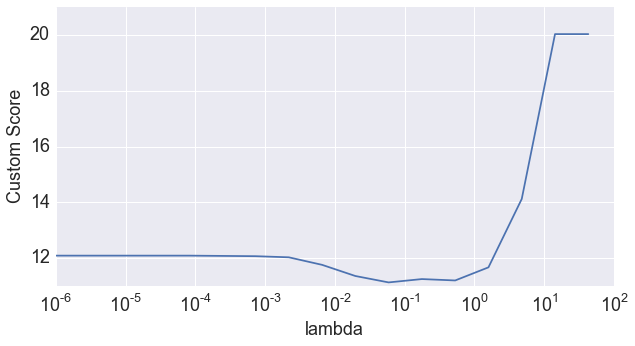

In [57]:
plot_lambda(lambda_lasso, coefs_lasso, mean_score_lambda_lasso)

####Use the best lambda value found above to find holdout values.

In [58]:
MSE_CV_lasso, MSE_T_lasso, MSE_H_lasso, high_MSE_cv_lasso, X_pred_cv_lasso, y_cv_lasso, df_cv_lasso, df_H_lasso = cross_validation_by_day(Lasso(alpha = best_lambda_lasso), all_features, df_tr, df_hold, days_tr, ref_column, cutoff_value)

Training RMSE: 8.2
Cross-Validation RMSE: 9.0 , High-Value CV RMSE: 19.0 , CV High Diff. in Mean (>40): -15.6
Holdout RMSE: 18.0 , High-Value Holdout RMSE: 30.0 , Holdout High Diff. in Mean.: -29.0


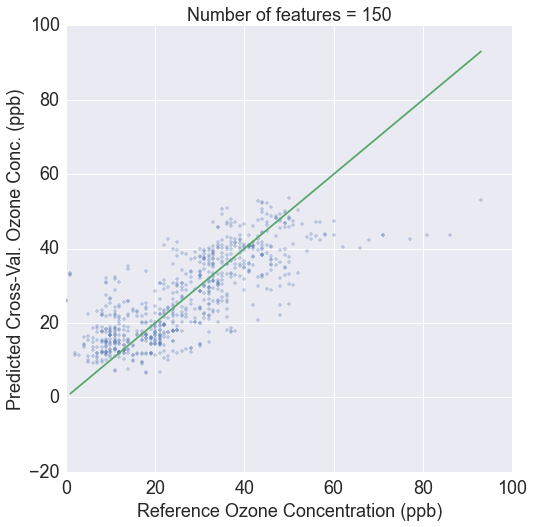

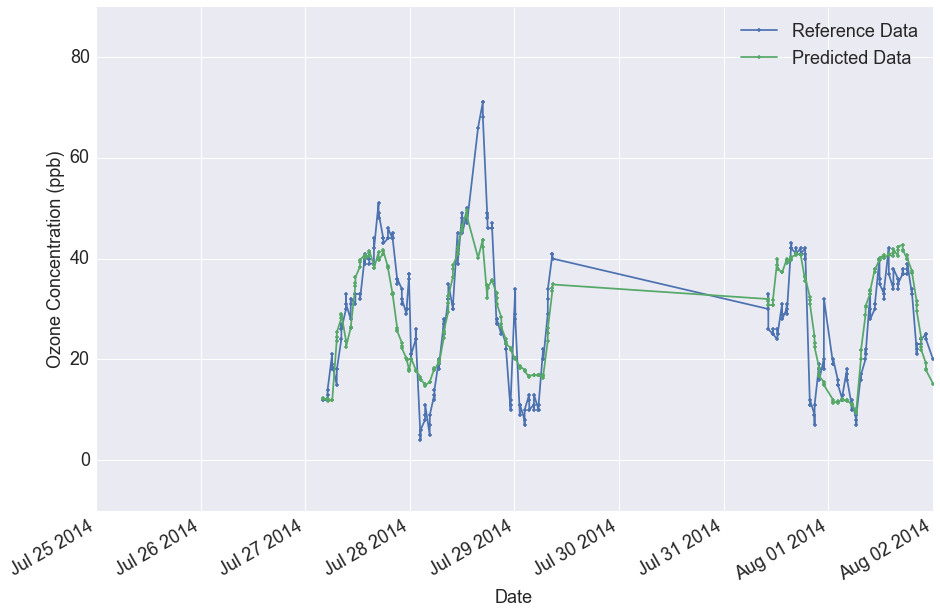

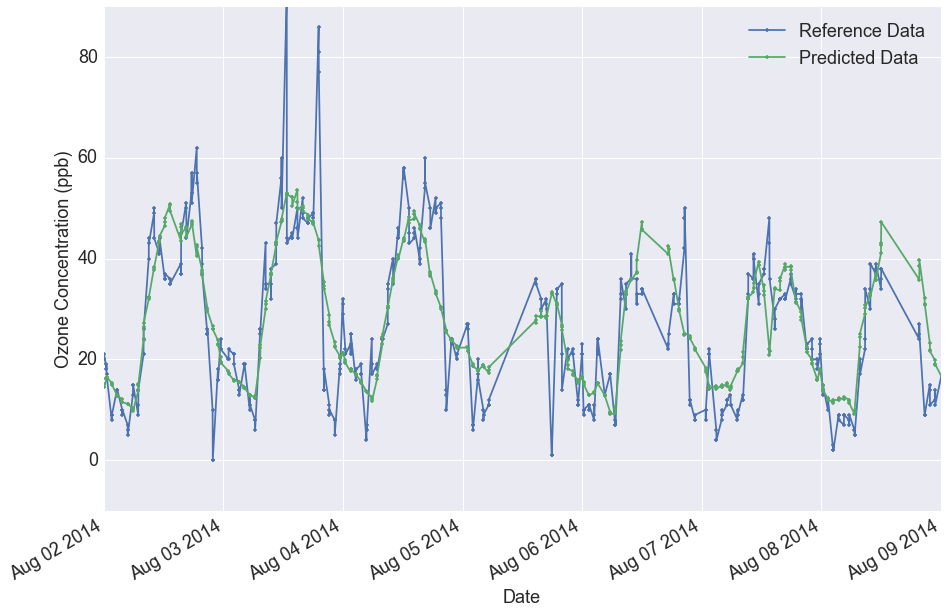

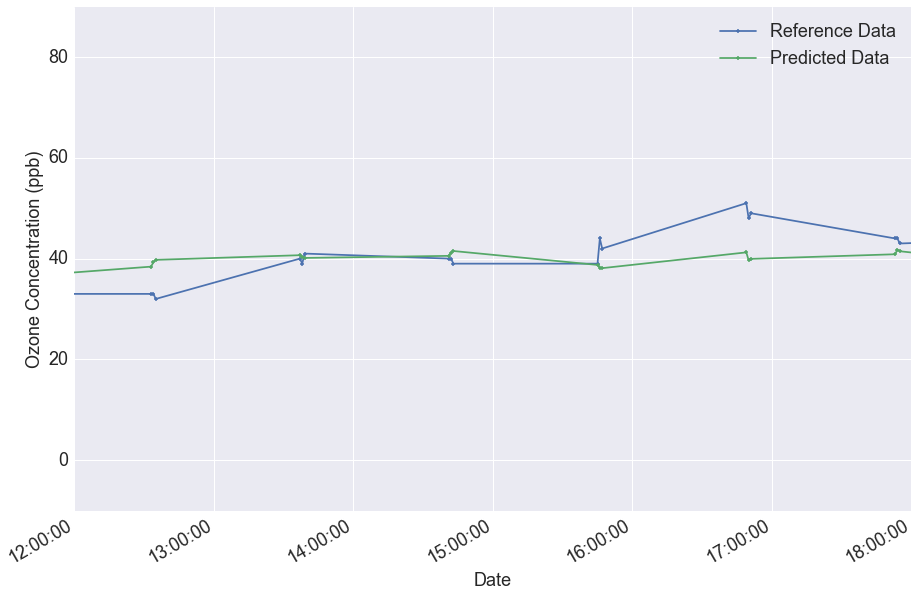

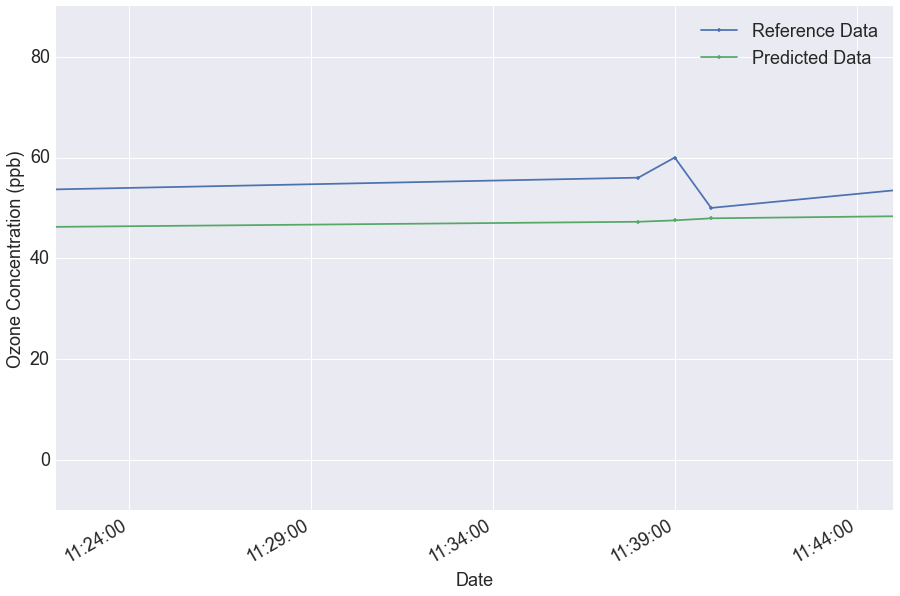

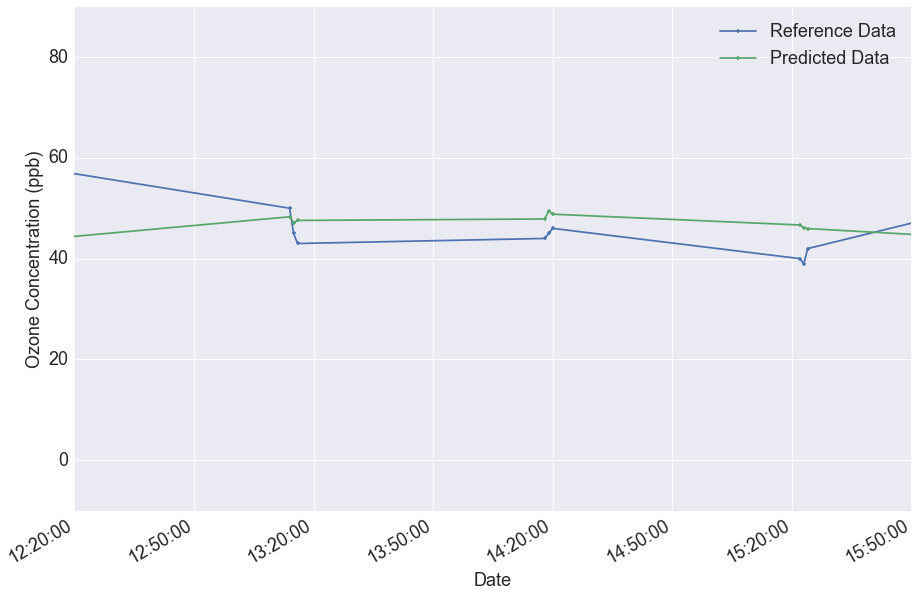

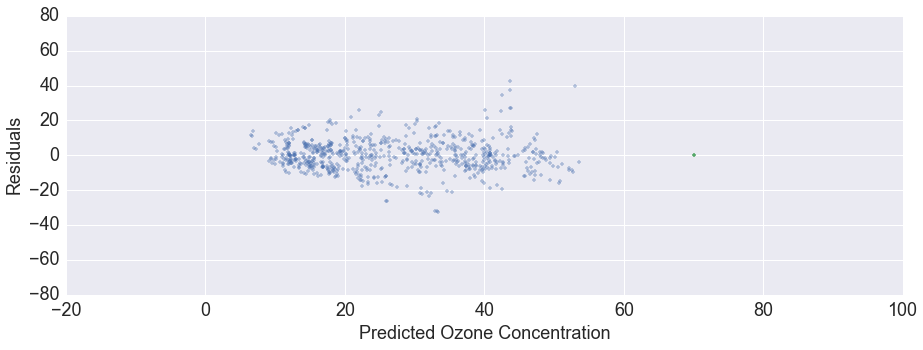

In [59]:
fitted_vs_ref_plot(df_cv_lasso, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_cv_lasso, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_cv_lasso, ref_column)

## Support Vector Machine- Best Features

In [67]:
RMSE_CV_day, df_svm_fit, df_H_svm = fit_svm_and_find_MSE(best_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
fitted_vs_ref_plot(df_svm_fit, num_good_feat_ridge, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit, ref_column)

## Support Vector Machine- All Features

In [68]:
RMSE_CV_day_all, df_svm_fit_all, df_H_svm_all = fit_svm_and_find_MSE(all_features, df_tr, days_tr, ref_column, cutoff_value, df_hold, cust_mse_fact)  

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
fitted_vs_ref_plot(df_svm_fit_all, len(all_features), ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_svm_fit_all, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_svm_fit_all, ref_column)

## Random Forest- All

In [74]:
MSE_CV, df_fit_rf = find_MSE_random_forest(df_fits, fs_features, days_tr, 0, ref_column)

7-27 Cross-Validation RMSE:  7.4
7-28 Cross-Validation RMSE:  8.8
7-29 Cross-Validation RMSE:  7.5
7-31 Cross-Validation RMSE:  8.1
8-1 Cross-Validation RMSE:  6.6
8-2 Cross-Validation RMSE:  7.9
8-3 Cross-Validation RMSE:  11.5
8-4 Cross-Validation RMSE:  9.3
8-5 Cross-Validation RMSE:  10.7
8-6 Cross-Validation RMSE:  14.6
8-7 Cross-Validation RMSE:  7.3
8-8 Cross-Validation RMSE:  7.7
8-9 Cross-Validation RMSE:  8.8
Overall RMSE: 8.94769957211


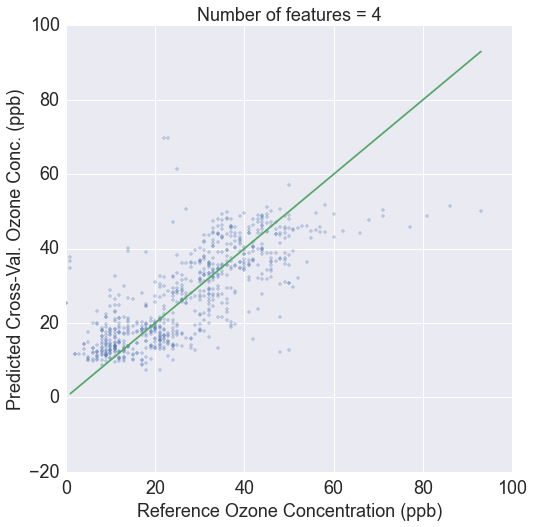

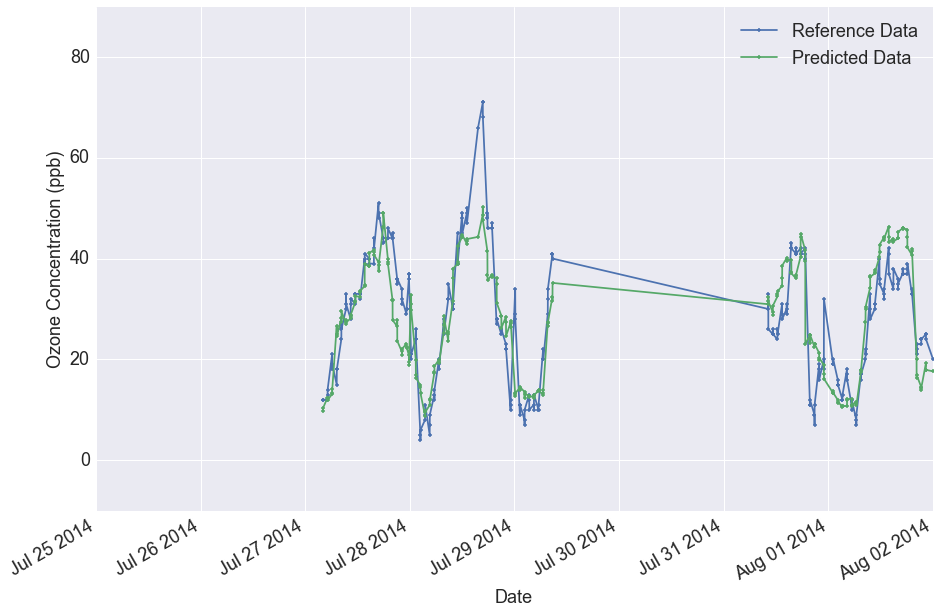

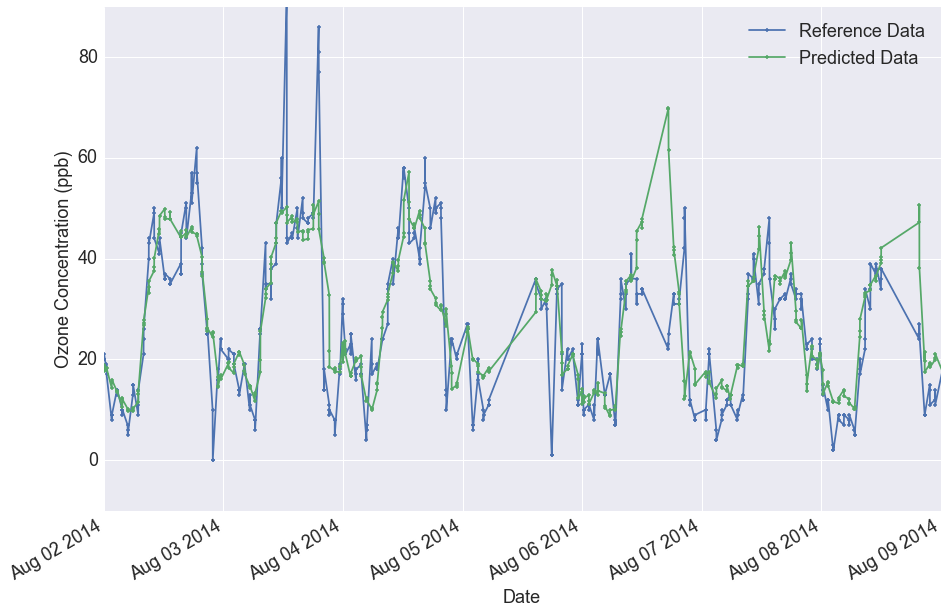

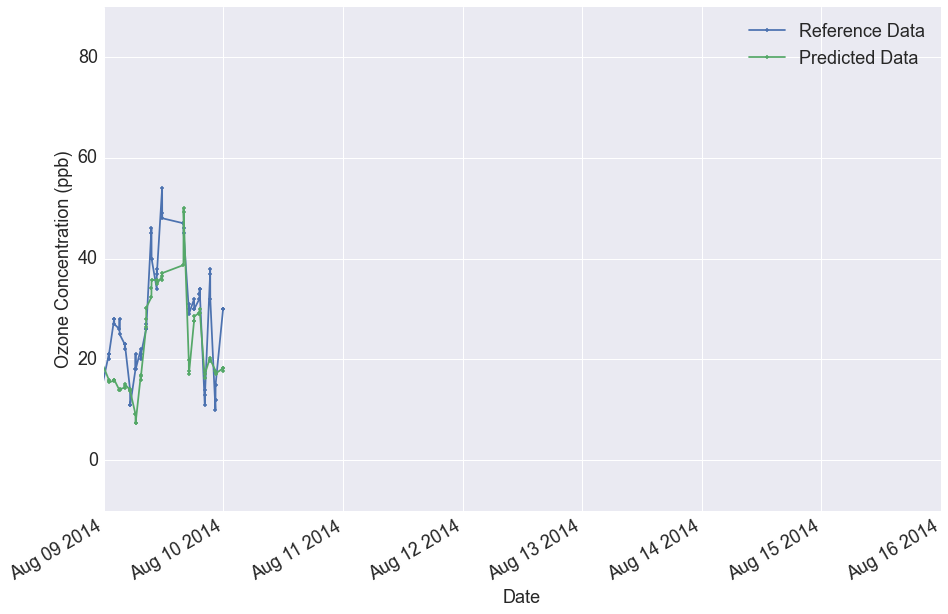

In [75]:
fitted_vs_ref_plot(df_fit_rf, num_good_feat, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf, pod_number, 3, ref_column)

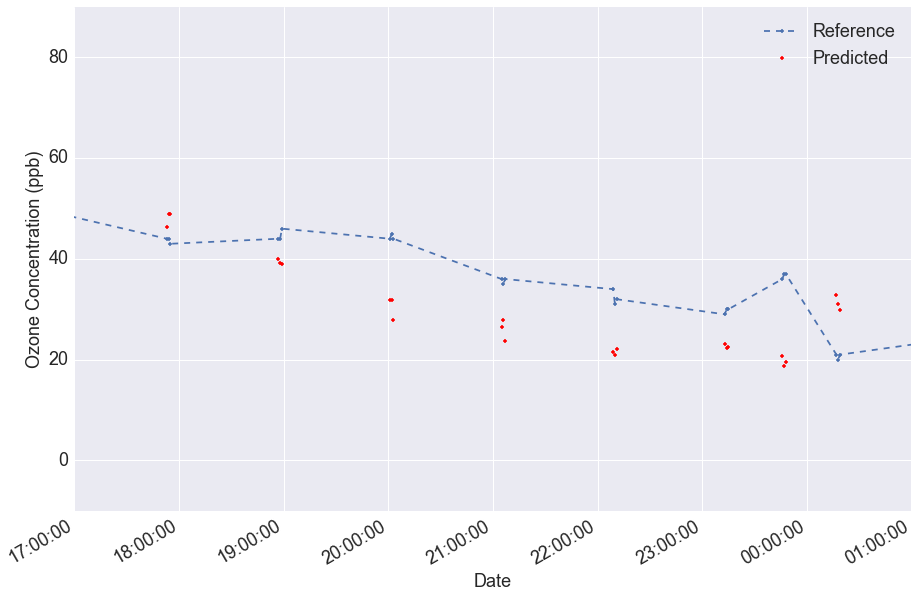

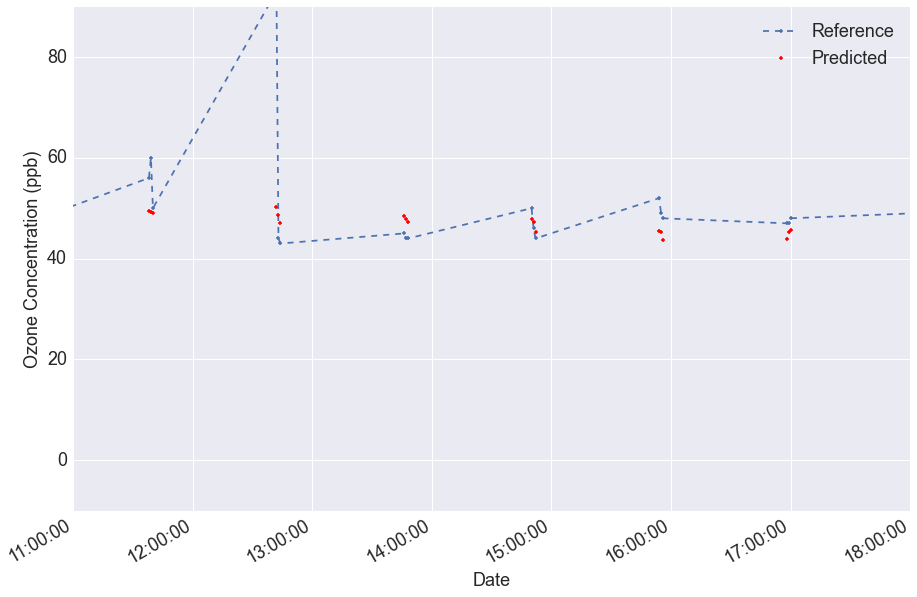

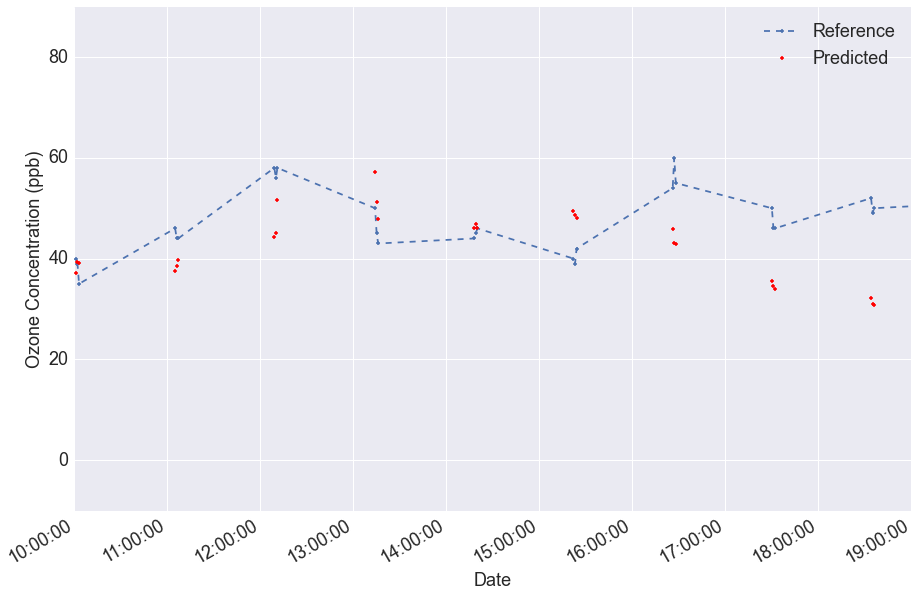

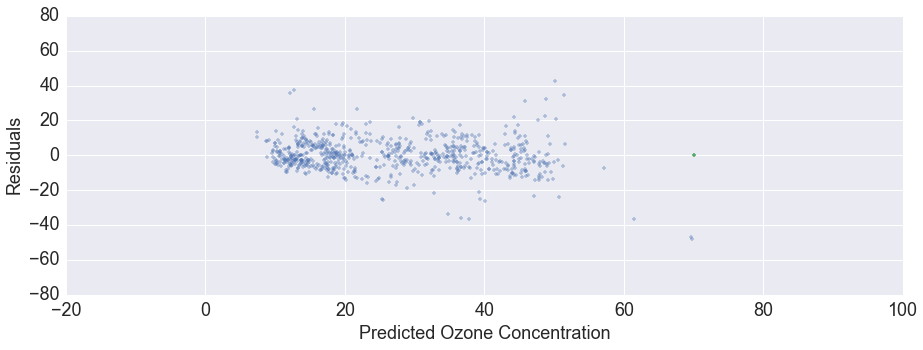

In [79]:
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time_no_lines(df_fit_rf, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf, ref_column)

## Random Forest- Base

In [71]:
MSE_CV_base, df_fit_rf_base = find_MSE_random_forest(df_fits, base_features, days_tr, 0, ref_column)

7-27 Cross-Validation RMSE:  12.5
7-28 Cross-Validation RMSE:  11.1
7-29 Cross-Validation RMSE:  8.4
7-31 Cross-Validation RMSE:  10.0
8-1 Cross-Validation RMSE:  8.6
8-2 Cross-Validation RMSE:  8.8
8-3 Cross-Validation RMSE:  13.6
8-4 Cross-Validation RMSE:  12.0
8-5 Cross-Validation RMSE:  13.3
8-6 Cross-Validation RMSE:  11.7
8-7 Cross-Validation RMSE:  11.1
8-8 Cross-Validation RMSE:  7.7
8-9 Cross-Validation RMSE:  9.4


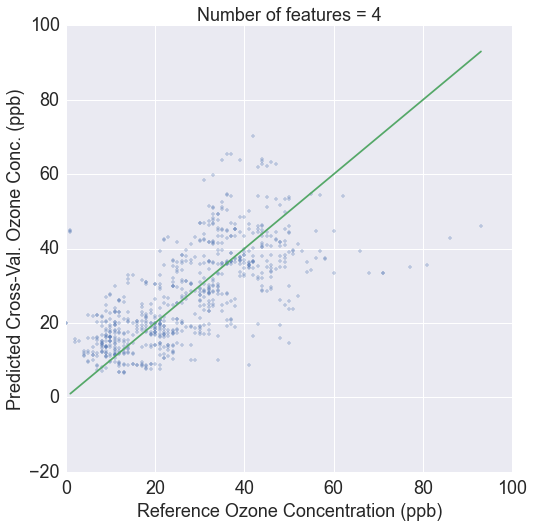

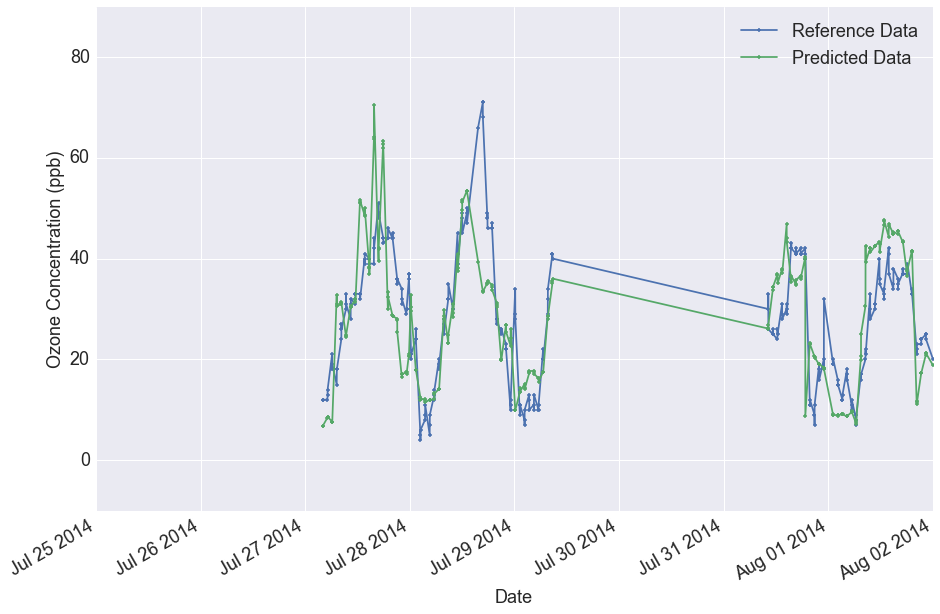

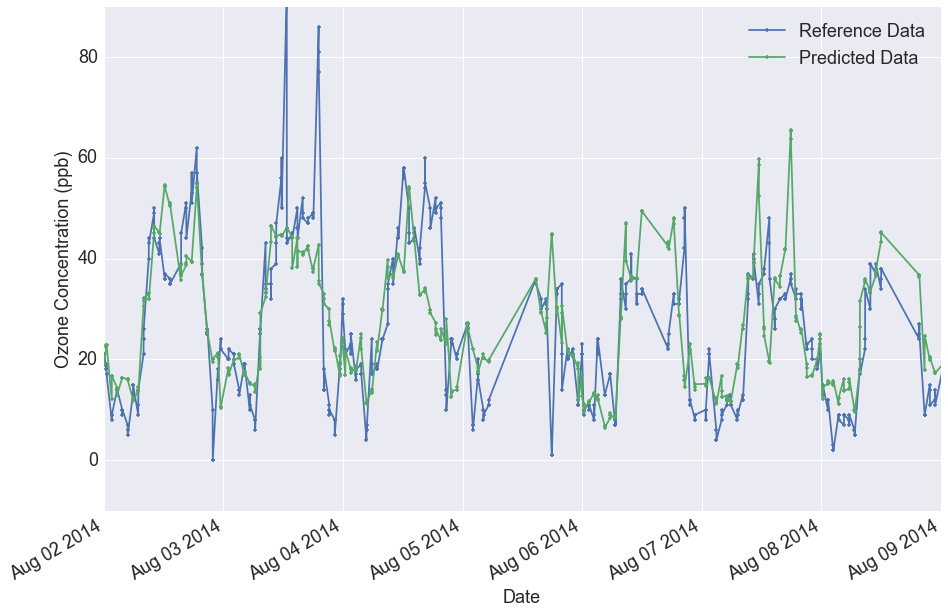

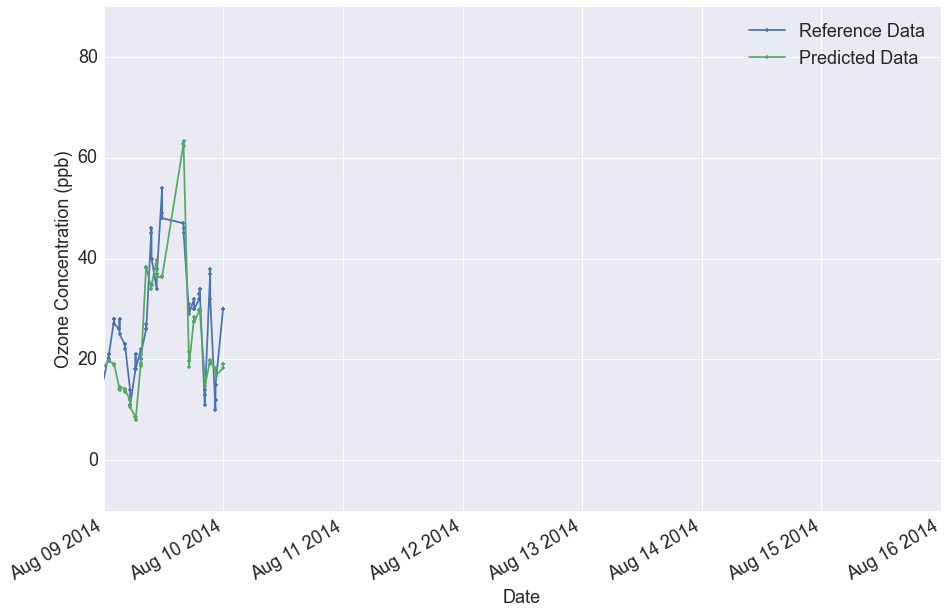

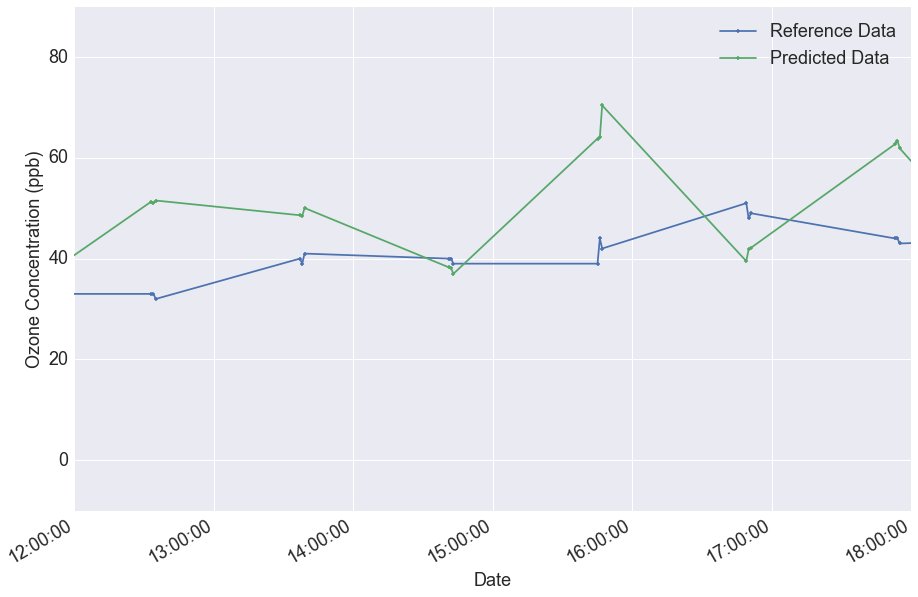

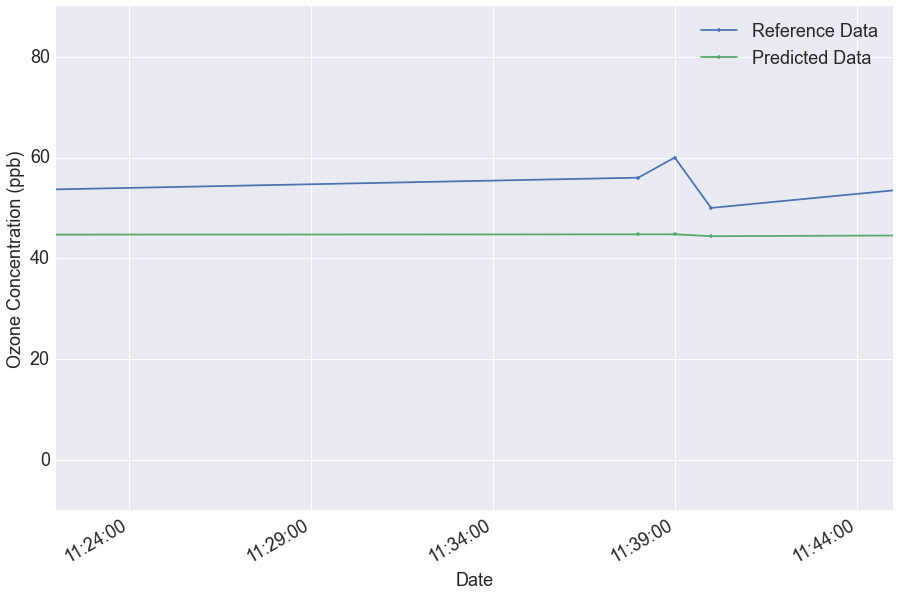

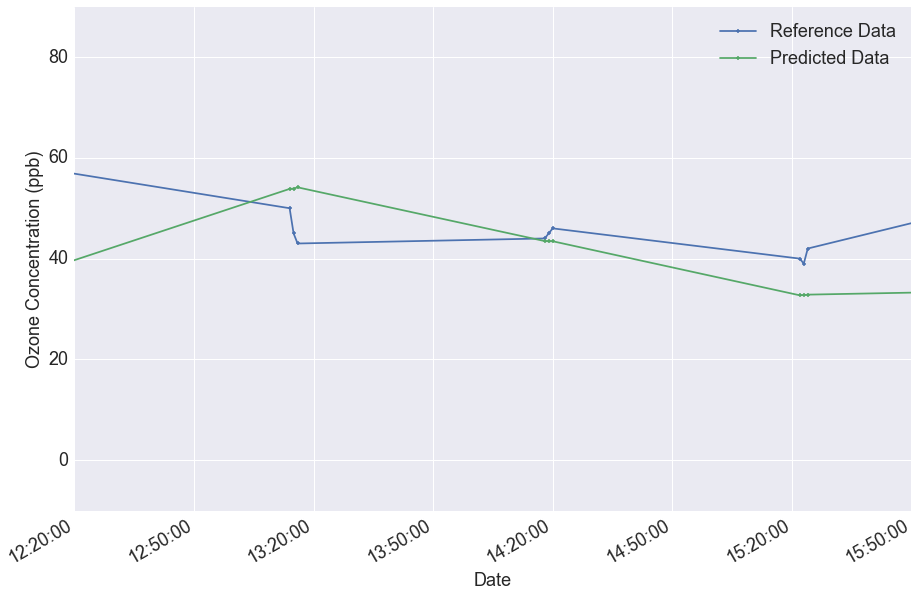

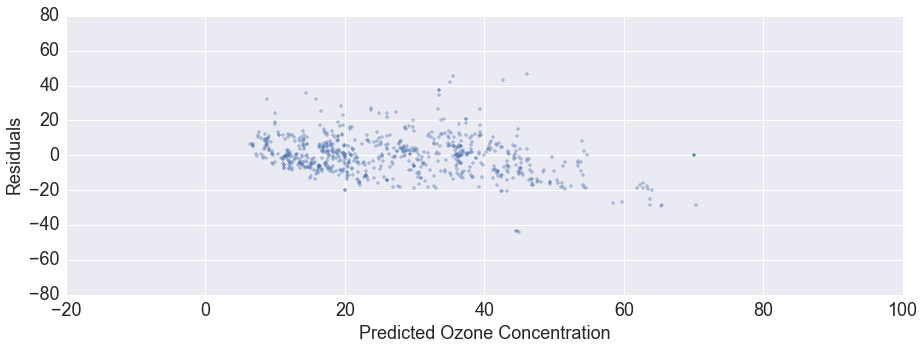

In [72]:
fitted_vs_ref_plot(df_fit_rf_base, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 1, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 2, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 3, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 4, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 5, ref_column)
plot_fitted_and_ref_vs_time(df_fit_rf_base, pod_number, 6, ref_column)
resid = plot_resid_vs_conc(df_fit_rf_base, ref_column)